<a href="https://colab.research.google.com/github/cghrios5/ds_tool/blob/main/DS_pipeline_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# import sklearn
path = '/content/drive/MyDrive/work/signate/pcgame_for_beginer/'
glob.glob(path+'*csv')

[]

In [ ]:
sample_submit = pd.read_csv('/content/drive/MyDrive/work/signate/pcgame_for_beginer/sample_submit.csv',header=None)
train = pd.read_csv('/content/drive/MyDrive/work/signate/pcgame_for_beginer/train.csv')
test = pd.read_csv('/content/drive/MyDrive/work/signate/pcgame_for_beginer/test.csv')
train.shape,test.shape,sample_submit.shape

((8000, 10), (2000, 9), (2000, 2))

In [ ]:
data = pd.concat([train,test])
data

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0.0
1,1,1,10,1,5,0,0,14536,17863,0.0
2,2,0,3,10,2,0,0,17409,17256,0.0
3,3,1,7,10,8,0,0,19558,18201,0.0
4,4,0,4,9,4,0,0,17409,17256,0.0
...,...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256,NaN
1996,9980,0,4,4,4,0,0,17409,17256,NaN
1997,9983,1,6,3,3,1,1,18513,18201,NaN
1998,9996,1,10,9,9,1,1,18513,18201,NaN


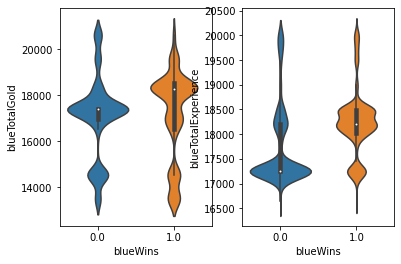

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1,2)

sns.violinplot(x ='blueWins',y='blueTotalGold',data=data,ax=axes[0])
sns.violinplot(x ='blueWins',y='blueTotalExperience',data=data,ax=axes[1])

In [ ]:
data['blueHeralds'] = data['blueEliteMonsters']-data['blueDragons']

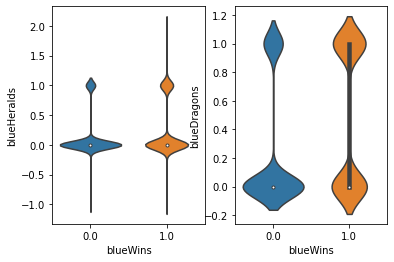

In [ ]:
data['blueHeralds'] = data['blueEliteMonsters']-data['blueDragons']
fig, axes = plt.subplots(1,2)
sns.violinplot(x ='blueWins',y='blueHeralds',data=data,ax=axes[0])
sns.violinplot(x ='blueWins',y='blueDragons',data=data,ax=axes[1])

In [ ]:
data['kda_plus']= data['blueKills']+data['blueAssists']-data['blueDeaths']
data['kda_multi']= (data['blueKills']*data['blueAssists'])/data['blueDeaths']
data['kda_multi'].replace(np.nan,0,inplace=True)
data['kda_multi'].replace(np.inf,200,inplace=True)

from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4)
# data['kmeans'] = kmeans.fit_predict(data.drop('blueWins',axis=1))
data

# todo ダミー化(GBDTだと順序を重視するので変わらないのが一般的であるが)

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueHeralds,kda_plus,kda_multi
0,0,0,5,8,6,0,0,14536,17256,0.0,0,3,3.750000
1,1,1,10,1,5,0,0,14536,17863,0.0,0,14,50.000000
2,2,0,3,10,2,0,0,17409,17256,0.0,0,-5,0.600000
3,3,1,7,10,8,0,0,19558,18201,0.0,0,5,5.600000
4,4,0,4,9,4,0,0,17409,17256,0.0,0,-1,1.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256,NaN,0,10,14.000000
1996,9980,0,4,4,4,0,0,17409,17256,NaN,0,4,4.000000
1997,9983,1,6,3,3,1,1,18513,18201,NaN,0,6,6.000000
1998,9996,1,10,9,9,1,1,18513,18201,NaN,0,10,10.000000


20619
[13475.         15645.56425643 19383.67886789 20619.        ]


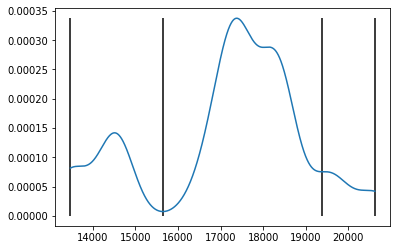

In [ ]:
def findMinima(data):
  kde = stats.kde.gaussian_kde(data,bw_method=0.222)
  x = np.linspace(data.min(),data.max(),num=len(data))
  print(data.max())
  kde_fit = kde(x)
  
  plt.plot(x,kde_fit)
  bins = x[signal.argrelmin(kde_fit)]
  bins = np.append(data.min(),bins)
  bins = np.append(bins,data.max())
  
  # グラフを見ながら消したい点を探す
  bins = np.delete(bins,2)
  
  plt.vlines(bins,0,kde_fit.max())
  print(bins)
  bined_data = pd.cut(data,bins,labels=range(len(bins)-1))
  return bined_data

# col_name = ['blueTotalGold','blueTotalExperience']
col_name = 'blueTotalGold'
data[col_name+'_cat'] = findMinima(data[col_name])
# data

In [ ]:
cols = ['blueHeralds','blueDragons']
for col in cols:
  group_ratio = train.groupby([col,'blueWins'])['blueWins'].count().unstack()
  group_ratio.fillna(0,inplace=True)
  state_ratio = group_ratio.iloc[:,1] / (group_ratio.iloc[:,0]+group_ratio.iloc[:,1])*100
  state_ratio
  data[col+'_state'] =  data[col].map(lambda x: state_ratio[x] ) #if x in train[col].unique() else np.nan


In [ ]:
group_ratio

blueWins,0,1
blueDragons,,
0,3093,2042
1,973,1892


In [ ]:

configs = {'blueDragons':800,
'blueHeralds': 1200,
'blueFirstBlood': 450,
'blueKills': 300,
'blueDeaths': -300,
'blueAssists': 50}

config_cols =list(configs.keys())

amount = 0
for col in configs.keys():
  print(col)
  amount+= data[col]*configs[col]
data['amount'] = amount

blueDragons
blueHeralds
blueFirstBlood
blueKills
blueDeaths
blueAssists


In [ ]:

one_hot_cols = ['blueFirstBlood','blueEliteMonsters', 'blueDragons','blueTotalGold_cat', 'blueTotalExperience_cat']
data = pd.get_dummies(data,columns=one_hot_cols)

data = data.drop(['gameId','blueFirstBlood','blueKills','blueDeaths','blueAssists'],axis=1)

y = data['blueWins']
x = data.drop('blueWins',axis=1)

x_train,x_test = x[:len(train)], x[len(train):]
y_train = y[:len(train)]
y_train


train_x, valid_x, train_y, valid_y = train_test_split(x_train,y_train,test_size=0.25,shuffle=True)
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape


((6000, 24), (2000, 24), (6000,), (2000,))

In [ ]:
!pip install optuna

     |████████████████████████████████| 286kB 8.4MB/s 
     |████████████████████████████████| 81kB 4.7MB/s 
     |████████████████████████████████| 163kB 12.1MB/s 
     |████████████████████████████████| 112kB 17.2MB/s 
     |████████████████████████████████| 133kB 14.7MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 481kB 16.3MB/s 
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=65a55a0a71630fd60e2977bf05aaf907ee937610e61edd433ce824b43dc88cd8
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=3ac0372c2b100e396aee62da1d817e8f6e76447812c09c64a7b2b15755a806b6
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha

In [ ]:
import optuna
import sklearn
def objective(trial):
    # data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    # train_x, test_x, train_y, test_y = train_test_split(x_train,y_train, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)
 
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(param, dtrain,valid_sets=dvalid)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-01-28 05:26:18,651] A new study created in memory with name: no-name-3b806875-2587-4510-836c-e68625ad842c


[1]	valid_0's binary_logloss: 0.655159
[2]	valid_0's binary_logloss: 0.623257
[3]	valid_0's binary_logloss: 0.602863
[4]	valid_0's binary_logloss: 0.579641
[5]	valid_0's binary_logloss: 0.560738
[6]	valid_0's binary_logloss: 0.544454
[7]	valid_0's binary_logloss: 0.531745
[8]	valid_0's binary_logloss: 0.523638
[9]	valid_0's binary_logloss: 0.512037
[10]	valid_0's binary_logloss: 0.502448
[11]	valid_0's binary_logloss: 0.494561
[12]	valid_0's binary_logloss: 0.488825
[13]	valid_0's binary_logloss: 0.481803
[14]	valid_0's binary_logloss: 0.476702
[15]	valid_0's binary_logloss: 0.471606
[16]	valid_0's binary_logloss: 0.469126
[17]	valid_0's binary_logloss: 0.46561
[18]	valid_0's binary_logloss: 0.463007
[19]	valid_0's binary_logloss: 0.460963
[20]	valid_0's binary_logloss: 0.460059
[21]	valid_0's binary_logloss: 0.459043
[22]	valid_0's binary_logloss: 0.457754
[23]	valid_0's binary_logloss: 0.45544
[24]	valid_0's binary_logloss: 0.454352
[25]	valid_0's binary_logloss: 0.45295
[26]	valid_0

[I 2021-01-28 05:26:19,048] Trial 0 finished with value: 0.781 and parameters: {'lambda_l1': 0.42138892163772274, 'lambda_l2': 1.8027385280407444e-07, 'num_leaves': 65, 'feature_fraction': 0.5852145437156673, 'bagging_fraction': 0.8932908453990138, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 0 with value: 0.781.


[64]	valid_0's binary_logloss: 0.445129
[65]	valid_0's binary_logloss: 0.444943
[66]	valid_0's binary_logloss: 0.445656
[67]	valid_0's binary_logloss: 0.445858
[68]	valid_0's binary_logloss: 0.445758
[69]	valid_0's binary_logloss: 0.445806
[70]	valid_0's binary_logloss: 0.445842
[71]	valid_0's binary_logloss: 0.445602
[72]	valid_0's binary_logloss: 0.445776
[73]	valid_0's binary_logloss: 0.446196
[74]	valid_0's binary_logloss: 0.445989
[75]	valid_0's binary_logloss: 0.44636
[76]	valid_0's binary_logloss: 0.447001
[77]	valid_0's binary_logloss: 0.447065
[78]	valid_0's binary_logloss: 0.447382
[79]	valid_0's binary_logloss: 0.447626
[80]	valid_0's binary_logloss: 0.448133
[81]	valid_0's binary_logloss: 0.448555
[82]	valid_0's binary_logloss: 0.448675
[83]	valid_0's binary_logloss: 0.449006
[84]	valid_0's binary_logloss: 0.449289
[85]	valid_0's binary_logloss: 0.449409
[86]	valid_0's binary_logloss: 0.450047
[87]	valid_0's binary_logloss: 0.450669
[88]	valid_0's binary_logloss: 0.451191
[

[I 2021-01-28 05:26:19,373] Trial 1 finished with value: 0.782 and parameters: {'lambda_l1': 1.2385536593718898e-05, 'lambda_l2': 3.836270999007653e-07, 'num_leaves': 50, 'feature_fraction': 0.8734034407614224, 'bagging_fraction': 0.5584023446867005, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 1 with value: 0.782.


[87]	valid_0's binary_logloss: 0.46742
[88]	valid_0's binary_logloss: 0.46788
[89]	valid_0's binary_logloss: 0.468739
[90]	valid_0's binary_logloss: 0.469745
[91]	valid_0's binary_logloss: 0.468266
[92]	valid_0's binary_logloss: 0.467752
[93]	valid_0's binary_logloss: 0.467706
[94]	valid_0's binary_logloss: 0.467791
[95]	valid_0's binary_logloss: 0.467811
[96]	valid_0's binary_logloss: 0.467936
[97]	valid_0's binary_logloss: 0.467981
[98]	valid_0's binary_logloss: 0.469043
[99]	valid_0's binary_logloss: 0.469759
[100]	valid_0's binary_logloss: 0.47045
[1]	valid_0's binary_logloss: 0.661896
[2]	valid_0's binary_logloss: 0.628259
[3]	valid_0's binary_logloss: 0.609207
[4]	valid_0's binary_logloss: 0.585126
[5]	valid_0's binary_logloss: 0.571131
[6]	valid_0's binary_logloss: 0.553749
[7]	valid_0's binary_logloss: 0.541068
[8]	valid_0's binary_logloss: 0.532679
[9]	valid_0's binary_logloss: 0.521118
[10]	valid_0's binary_logloss: 0.514112
[11]	valid_0's binary_logloss: 0.507377
[12]	valid_

[I 2021-01-28 05:26:19,778] Trial 2 finished with value: 0.7825 and parameters: {'lambda_l1': 1.6136258154170233, 'lambda_l2': 0.0036510226254385806, 'num_leaves': 245, 'feature_fraction': 0.4593972210272808, 'bagging_fraction': 0.7893983632450295, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 2 with value: 0.7825.



[92]	valid_0's binary_logloss: 0.447754
[93]	valid_0's binary_logloss: 0.447449
[94]	valid_0's binary_logloss: 0.447452
[95]	valid_0's binary_logloss: 0.446988
[96]	valid_0's binary_logloss: 0.447396
[97]	valid_0's binary_logloss: 0.447769
[98]	valid_0's binary_logloss: 0.447885
[99]	valid_0's binary_logloss: 0.447511
[100]	valid_0's binary_logloss: 0.447384
[1]	valid_0's binary_logloss: 0.656223
[2]	valid_0's binary_logloss: 0.625894
[3]	valid_0's binary_logloss: 0.600555
[4]	valid_0's binary_logloss: 0.578865
[5]	valid_0's binary_logloss: 0.560128
[6]	valid_0's binary_logloss: 0.544799
[7]	valid_0's binary_logloss: 0.532175
[8]	valid_0's binary_logloss: 0.521122
[9]	valid_0's binary_logloss: 0.511637
[10]	valid_0's binary_logloss: 0.50364
[11]	valid_0's binary_logloss: 0.496112
[12]	valid_0's binary_logloss: 0.489164
[13]	valid_0's binary_logloss: 0.482761
[14]	valid_0's binary_logloss: 0.478091
[15]	valid_0's binary_logloss: 0.473354
[16]	valid_0's binary_logloss: 0.47082
[17]	vali

[I 2021-01-28 05:26:20,106] Trial 3 finished with value: 0.788 and parameters: {'lambda_l1': 0.0004308199899779725, 'lambda_l2': 1.7809151046699718e-06, 'num_leaves': 239, 'feature_fraction': 0.9169656383369983, 'bagging_fraction': 0.5523727030778217, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 3 with value: 0.788.


[37]	valid_0's binary_logloss: 0.444184
[38]	valid_0's binary_logloss: 0.443429
[39]	valid_0's binary_logloss: 0.443362
[40]	valid_0's binary_logloss: 0.443494
[41]	valid_0's binary_logloss: 0.44416
[42]	valid_0's binary_logloss: 0.444435
[43]	valid_0's binary_logloss: 0.443643
[44]	valid_0's binary_logloss: 0.443118
[45]	valid_0's binary_logloss: 0.442879
[46]	valid_0's binary_logloss: 0.442583
[47]	valid_0's binary_logloss: 0.442472
[48]	valid_0's binary_logloss: 0.442692
[49]	valid_0's binary_logloss: 0.443263
[50]	valid_0's binary_logloss: 0.443056
[51]	valid_0's binary_logloss: 0.443108
[52]	valid_0's binary_logloss: 0.442911
[53]	valid_0's binary_logloss: 0.44256
[54]	valid_0's binary_logloss: 0.442743
[55]	valid_0's binary_logloss: 0.44264
[56]	valid_0's binary_logloss: 0.443571
[57]	valid_0's binary_logloss: 0.443467
[58]	valid_0's binary_logloss: 0.443609
[59]	valid_0's binary_logloss: 0.443374
[60]	valid_0's binary_logloss: 0.443659
[61]	valid_0's binary_logloss: 0.443338
[62

[I 2021-01-28 05:26:20,461] Trial 4 finished with value: 0.7895 and parameters: {'lambda_l1': 3.8079886642316224e-07, 'lambda_l2': 5.2797624581868754e-08, 'num_leaves': 69, 'feature_fraction': 0.9238263808420464, 'bagging_fraction': 0.48327085549121773, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 4 with value: 0.7895.



[68]	valid_0's binary_logloss: 0.442816
[69]	valid_0's binary_logloss: 0.442698
[70]	valid_0's binary_logloss: 0.443802
[71]	valid_0's binary_logloss: 0.443641
[72]	valid_0's binary_logloss: 0.443905
[73]	valid_0's binary_logloss: 0.443594
[74]	valid_0's binary_logloss: 0.443458
[75]	valid_0's binary_logloss: 0.443287
[76]	valid_0's binary_logloss: 0.443233
[77]	valid_0's binary_logloss: 0.443817
[78]	valid_0's binary_logloss: 0.444166
[79]	valid_0's binary_logloss: 0.4448
[80]	valid_0's binary_logloss: 0.445581
[81]	valid_0's binary_logloss: 0.445679
[82]	valid_0's binary_logloss: 0.446016
[83]	valid_0's binary_logloss: 0.446671
[84]	valid_0's binary_logloss: 0.446751
[85]	valid_0's binary_logloss: 0.446507
[86]	valid_0's binary_logloss: 0.447184
[87]	valid_0's binary_logloss: 0.44681
[88]	valid_0's binary_logloss: 0.446677
[89]	valid_0's binary_logloss: 0.447138
[90]	valid_0's binary_logloss: 0.44752
[91]	valid_0's binary_logloss: 0.448275
[92]	valid_0's binary_logloss: 0.44845
[93]

[I 2021-01-28 05:26:21,350] Trial 5 finished with value: 0.769 and parameters: {'lambda_l1': 4.678507383320482e-06, 'lambda_l2': 0.03571983114496111, 'num_leaves': 252, 'feature_fraction': 0.890346743368188, 'bagging_fraction': 0.9656628022414115, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 4 with value: 0.7895.


[98]	valid_0's binary_logloss: 0.531732
[99]	valid_0's binary_logloss: 0.533402
[100]	valid_0's binary_logloss: 0.53527
[1]	valid_0's binary_logloss: 0.65448
[2]	valid_0's binary_logloss: 0.623206
[3]	valid_0's binary_logloss: 0.60092
[4]	valid_0's binary_logloss: 0.579347
[5]	valid_0's binary_logloss: 0.559673
[6]	valid_0's binary_logloss: 0.543428
[7]	valid_0's binary_logloss: 0.530234
[8]	valid_0's binary_logloss: 0.52043
[9]	valid_0's binary_logloss: 0.509573
[10]	valid_0's binary_logloss: 0.500137
[11]	valid_0's binary_logloss: 0.491584
[12]	valid_0's binary_logloss: 0.484714
[13]	valid_0's binary_logloss: 0.479154
[14]	valid_0's binary_logloss: 0.474607
[15]	valid_0's binary_logloss: 0.470016
[16]	valid_0's binary_logloss: 0.466614
[17]	valid_0's binary_logloss: 0.464039
[18]	valid_0's binary_logloss: 0.461903
[19]	valid_0's binary_logloss: 0.459799
[20]	valid_0's binary_logloss: 0.458469
[21]	valid_0's binary_logloss: 0.457947
[22]	valid_0's binary_logloss: 0.457124
[23]	valid_0

[I 2021-01-28 05:26:21,793] Trial 6 finished with value: 0.788 and parameters: {'lambda_l1': 2.1003746155300793e-06, 'lambda_l2': 0.0012033806765220474, 'num_leaves': 182, 'feature_fraction': 0.7308664373955747, 'bagging_fraction': 0.5497091706733229, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 4 with value: 0.7895.


[59]	valid_0's binary_logloss: 0.449316
[60]	valid_0's binary_logloss: 0.449458
[61]	valid_0's binary_logloss: 0.448762
[62]	valid_0's binary_logloss: 0.448829
[63]	valid_0's binary_logloss: 0.449101
[64]	valid_0's binary_logloss: 0.449045
[65]	valid_0's binary_logloss: 0.449269
[66]	valid_0's binary_logloss: 0.449804
[67]	valid_0's binary_logloss: 0.44982
[68]	valid_0's binary_logloss: 0.450748
[69]	valid_0's binary_logloss: 0.451245
[70]	valid_0's binary_logloss: 0.452618
[71]	valid_0's binary_logloss: 0.453542
[72]	valid_0's binary_logloss: 0.454235
[73]	valid_0's binary_logloss: 0.454817
[74]	valid_0's binary_logloss: 0.454585
[75]	valid_0's binary_logloss: 0.455315
[76]	valid_0's binary_logloss: 0.456057
[77]	valid_0's binary_logloss: 0.45638
[78]	valid_0's binary_logloss: 0.45612
[79]	valid_0's binary_logloss: 0.456386
[80]	valid_0's binary_logloss: 0.456659
[81]	valid_0's binary_logloss: 0.456563
[82]	valid_0's binary_logloss: 0.456245
[83]	valid_0's binary_logloss: 0.456323
[84

[I 2021-01-28 05:26:22,253] Trial 7 finished with value: 0.7925 and parameters: {'lambda_l1': 9.961499536746161e-06, 'lambda_l2': 0.00016377963460042542, 'num_leaves': 154, 'feature_fraction': 0.5508814136937517, 'bagging_fraction': 0.7550277677611656, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 7 with value: 0.7925.
[I 2021-01-28 05:26:22,411] Trial 8 finished with value: 0.7895 and parameters: {'lambda_l1': 0.09004888833403883, 'lambda_l2': 6.463934230527102e-06, 'num_leaves': 6, 'feature_fraction': 0.8344725320640388, 'bagging_fraction': 0.47797075839412495, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 7 with value: 0.7925.


[1]	valid_0's binary_logloss: 0.661039
[2]	valid_0's binary_logloss: 0.634569
[3]	valid_0's binary_logloss: 0.61022
[4]	valid_0's binary_logloss: 0.589882
[5]	valid_0's binary_logloss: 0.573244
[6]	valid_0's binary_logloss: 0.558647
[7]	valid_0's binary_logloss: 0.546688
[8]	valid_0's binary_logloss: 0.538492
[9]	valid_0's binary_logloss: 0.529313
[10]	valid_0's binary_logloss: 0.521338
[11]	valid_0's binary_logloss: 0.514663
[12]	valid_0's binary_logloss: 0.509066
[13]	valid_0's binary_logloss: 0.504362
[14]	valid_0's binary_logloss: 0.500951
[15]	valid_0's binary_logloss: 0.497054
[16]	valid_0's binary_logloss: 0.494224
[17]	valid_0's binary_logloss: 0.49052
[18]	valid_0's binary_logloss: 0.488356
[19]	valid_0's binary_logloss: 0.484969
[20]	valid_0's binary_logloss: 0.483118
[21]	valid_0's binary_logloss: 0.481744
[22]	valid_0's binary_logloss: 0.480322
[23]	valid_0's binary_logloss: 0.478424
[24]	valid_0's binary_logloss: 0.477456
[25]	valid_0's binary_logloss: 0.475065
[26]	valid_

[I 2021-01-28 05:26:22,843] Trial 9 finished with value: 0.787 and parameters: {'lambda_l1': 4.37546217438201e-08, 'lambda_l2': 0.002822754144569189, 'num_leaves': 201, 'feature_fraction': 0.8817130157581806, 'bagging_fraction': 0.7448324070156567, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 7 with value: 0.7925.


[69]	valid_0's binary_logloss: 0.445653
[70]	valid_0's binary_logloss: 0.445926
[71]	valid_0's binary_logloss: 0.446453
[72]	valid_0's binary_logloss: 0.446548
[73]	valid_0's binary_logloss: 0.446653
[74]	valid_0's binary_logloss: 0.446893
[75]	valid_0's binary_logloss: 0.447207
[76]	valid_0's binary_logloss: 0.447579
[77]	valid_0's binary_logloss: 0.44772
[78]	valid_0's binary_logloss: 0.448071
[79]	valid_0's binary_logloss: 0.448778
[80]	valid_0's binary_logloss: 0.44901
[81]	valid_0's binary_logloss: 0.449065
[82]	valid_0's binary_logloss: 0.449138
[83]	valid_0's binary_logloss: 0.449625
[84]	valid_0's binary_logloss: 0.449326
[85]	valid_0's binary_logloss: 0.449642
[86]	valid_0's binary_logloss: 0.450279
[87]	valid_0's binary_logloss: 0.450432
[88]	valid_0's binary_logloss: 0.451002
[89]	valid_0's binary_logloss: 0.450609
[90]	valid_0's binary_logloss: 0.450533
[91]	valid_0's binary_logloss: 0.451306
[92]	valid_0's binary_logloss: 0.4516
[93]	valid_0's binary_logloss: 0.451831
[94]

[I 2021-01-28 05:26:23,162] Trial 10 finished with value: 0.792 and parameters: {'lambda_l1': 0.0036314314567519445, 'lambda_l2': 6.4371029857742945, 'num_leaves': 158, 'feature_fraction': 0.4081458492197588, 'bagging_fraction': 0.6618826367949863, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 7 with value: 0.7925.


[87]	valid_0's binary_logloss: 0.440899
[88]	valid_0's binary_logloss: 0.440685
[89]	valid_0's binary_logloss: 0.440778
[90]	valid_0's binary_logloss: 0.440519
[91]	valid_0's binary_logloss: 0.440628
[92]	valid_0's binary_logloss: 0.439954
[93]	valid_0's binary_logloss: 0.439507
[94]	valid_0's binary_logloss: 0.439005
[95]	valid_0's binary_logloss: 0.439259
[96]	valid_0's binary_logloss: 0.438995
[97]	valid_0's binary_logloss: 0.439416
[98]	valid_0's binary_logloss: 0.439461
[99]	valid_0's binary_logloss: 0.439322
[100]	valid_0's binary_logloss: 0.439507
[1]	valid_0's binary_logloss: 0.664801
[2]	valid_0's binary_logloss: 0.635452
[3]	valid_0's binary_logloss: 0.616525
[4]	valid_0's binary_logloss: 0.604228
[5]	valid_0's binary_logloss: 0.588875
[6]	valid_0's binary_logloss: 0.569009
[7]	valid_0's binary_logloss: 0.555793
[8]	valid_0's binary_logloss: 0.546359
[9]	valid_0's binary_logloss: 0.536376
[10]	valid_0's binary_logloss: 0.528856
[11]	valid_0's binary_logloss: 0.521647
[12]	val

[I 2021-01-28 05:26:23,470] Trial 11 finished with value: 0.7875 and parameters: {'lambda_l1': 0.0013453327288199565, 'lambda_l2': 5.876906047010788, 'num_leaves': 135, 'feature_fraction': 0.4241946418888845, 'bagging_fraction': 0.644868255002594, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 7 with value: 0.7925.


[45]	valid_0's binary_logloss: 0.450015
[46]	valid_0's binary_logloss: 0.448955
[47]	valid_0's binary_logloss: 0.448493
[48]	valid_0's binary_logloss: 0.447353
[49]	valid_0's binary_logloss: 0.447334
[50]	valid_0's binary_logloss: 0.446259
[51]	valid_0's binary_logloss: 0.446328
[52]	valid_0's binary_logloss: 0.446426
[53]	valid_0's binary_logloss: 0.446557
[54]	valid_0's binary_logloss: 0.446296
[55]	valid_0's binary_logloss: 0.446532
[56]	valid_0's binary_logloss: 0.445502
[57]	valid_0's binary_logloss: 0.444642
[58]	valid_0's binary_logloss: 0.444192
[59]	valid_0's binary_logloss: 0.444213
[60]	valid_0's binary_logloss: 0.44445
[61]	valid_0's binary_logloss: 0.443436
[62]	valid_0's binary_logloss: 0.443458
[63]	valid_0's binary_logloss: 0.443391
[64]	valid_0's binary_logloss: 0.443335
[65]	valid_0's binary_logloss: 0.443753
[66]	valid_0's binary_logloss: 0.443353
[67]	valid_0's binary_logloss: 0.443026
[68]	valid_0's binary_logloss: 0.443067
[69]	valid_0's binary_logloss: 0.442975
[

[I 2021-01-28 05:26:23,827] Trial 12 finished with value: 0.7885 and parameters: {'lambda_l1': 0.01384730206275277, 'lambda_l2': 5.412073298607827, 'num_leaves': 138, 'feature_fraction': 0.5293488978817824, 'bagging_fraction': 0.8319372911661345, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 7 with value: 0.7925.


[78]	valid_0's binary_logloss: 0.434799
[79]	valid_0's binary_logloss: 0.434912
[80]	valid_0's binary_logloss: 0.435026
[81]	valid_0's binary_logloss: 0.435737
[82]	valid_0's binary_logloss: 0.435578
[83]	valid_0's binary_logloss: 0.435609
[84]	valid_0's binary_logloss: 0.435745
[85]	valid_0's binary_logloss: 0.435503
[86]	valid_0's binary_logloss: 0.435282
[87]	valid_0's binary_logloss: 0.435524
[88]	valid_0's binary_logloss: 0.435446
[89]	valid_0's binary_logloss: 0.43568
[90]	valid_0's binary_logloss: 0.435742
[91]	valid_0's binary_logloss: 0.436071
[92]	valid_0's binary_logloss: 0.436023
[93]	valid_0's binary_logloss: 0.436073
[94]	valid_0's binary_logloss: 0.436019
[95]	valid_0's binary_logloss: 0.43623
[96]	valid_0's binary_logloss: 0.436243
[97]	valid_0's binary_logloss: 0.436573
[98]	valid_0's binary_logloss: 0.436573
[99]	valid_0's binary_logloss: 0.436282
[100]	valid_0's binary_logloss: 0.436512
[1]	valid_0's binary_logloss: 0.655364
[2]	valid_0's binary_logloss: 0.625291
[3]

[I 2021-01-28 05:26:24,240] Trial 13 finished with value: 0.7865 and parameters: {'lambda_l1': 8.256932220525856e-05, 'lambda_l2': 4.738805434182019e-05, 'num_leaves': 176, 'feature_fraction': 0.6291365227604563, 'bagging_fraction': 0.6770574624699337, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 7 with value: 0.7925.



[81]	valid_0's binary_logloss: 0.448442
[82]	valid_0's binary_logloss: 0.448581
[83]	valid_0's binary_logloss: 0.448925
[84]	valid_0's binary_logloss: 0.449001
[85]	valid_0's binary_logloss: 0.449236
[86]	valid_0's binary_logloss: 0.449543
[87]	valid_0's binary_logloss: 0.44982
[88]	valid_0's binary_logloss: 0.450434
[89]	valid_0's binary_logloss: 0.450454
[90]	valid_0's binary_logloss: 0.451202
[91]	valid_0's binary_logloss: 0.450808
[92]	valid_0's binary_logloss: 0.450892
[93]	valid_0's binary_logloss: 0.450732
[94]	valid_0's binary_logloss: 0.451024
[95]	valid_0's binary_logloss: 0.451571
[96]	valid_0's binary_logloss: 0.452652
[97]	valid_0's binary_logloss: 0.453263
[98]	valid_0's binary_logloss: 0.453916
[99]	valid_0's binary_logloss: 0.454075
[100]	valid_0's binary_logloss: 0.455391
[1]	valid_0's binary_logloss: 0.661419
[2]	valid_0's binary_logloss: 0.630301
[3]	valid_0's binary_logloss: 0.610867
[4]	valid_0's binary_logloss: 0.597989
[5]	valid_0's binary_logloss: 0.582771
[6]	

[I 2021-01-28 05:26:24,591] Trial 14 finished with value: 0.792 and parameters: {'lambda_l1': 0.007002249336266024, 'lambda_l2': 0.07924896012024653, 'num_leaves': 101, 'feature_fraction': 0.40007688762423976, 'bagging_fraction': 0.6359726954208297, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 7 with value: 0.7925.



[98]	valid_0's binary_logloss: 0.445112
[99]	valid_0's binary_logloss: 0.444933
[100]	valid_0's binary_logloss: 0.444992
[1]	valid_0's binary_logloss: 0.660037
[2]	valid_0's binary_logloss: 0.625793
[3]	valid_0's binary_logloss: 0.606069
[4]	valid_0's binary_logloss: 0.581212
[5]	valid_0's binary_logloss: 0.563976
[6]	valid_0's binary_logloss: 0.545807
[7]	valid_0's binary_logloss: 0.532566
[8]	valid_0's binary_logloss: 0.523583
[9]	valid_0's binary_logloss: 0.510491
[10]	valid_0's binary_logloss: 0.50293
[11]	valid_0's binary_logloss: 0.494123
[12]	valid_0's binary_logloss: 0.488665
[13]	valid_0's binary_logloss: 0.482451
[14]	valid_0's binary_logloss: 0.478158
[15]	valid_0's binary_logloss: 0.472739
[16]	valid_0's binary_logloss: 0.470796
[17]	valid_0's binary_logloss: 0.467441
[18]	valid_0's binary_logloss: 0.466403
[19]	valid_0's binary_logloss: 0.463913
[20]	valid_0's binary_logloss: 0.463934
[21]	valid_0's binary_logloss: 0.462681
[22]	valid_0's binary_logloss: 0.461947
[23]	val

[I 2021-01-28 05:26:25,212] Trial 15 finished with value: 0.766 and parameters: {'lambda_l1': 6.247036089913907e-05, 'lambda_l2': 0.00013055251669930867, 'num_leaves': 154, 'feature_fraction': 0.523793792446467, 'bagging_fraction': 0.728233842179582, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 7 with value: 0.7925.


[1]	valid_0's binary_logloss: 0.655467
[2]	valid_0's binary_logloss: 0.625699
[3]	valid_0's binary_logloss: 0.604297
[4]	valid_0's binary_logloss: 0.583319
[5]	valid_0's binary_logloss: 0.564154
[6]	valid_0's binary_logloss: 0.548667
[7]	valid_0's binary_logloss: 0.534506
[8]	valid_0's binary_logloss: 0.524581
[9]	valid_0's binary_logloss: 0.513539
[10]	valid_0's binary_logloss: 0.504339
[11]	valid_0's binary_logloss: 0.49635
[12]	valid_0's binary_logloss: 0.490149
[13]	valid_0's binary_logloss: 0.483977
[14]	valid_0's binary_logloss: 0.479959
[15]	valid_0's binary_logloss: 0.474812
[16]	valid_0's binary_logloss: 0.47123
[17]	valid_0's binary_logloss: 0.467804
[18]	valid_0's binary_logloss: 0.465461
[19]	valid_0's binary_logloss: 0.463721
[20]	valid_0's binary_logloss: 0.462212
[21]	valid_0's binary_logloss: 0.461188
[22]	valid_0's binary_logloss: 0.459785
[23]	valid_0's binary_logloss: 0.457865
[24]	valid_0's binary_logloss: 0.456426
[25]	valid_0's binary_logloss: 0.454984
[26]	valid_

[I 2021-01-28 05:26:25,620] Trial 16 finished with value: 0.785 and parameters: {'lambda_l1': 2.1930017275997928e-08, 'lambda_l2': 0.7570918831150578, 'num_leaves': 213, 'feature_fraction': 0.7060117421478977, 'bagging_fraction': 0.8710899647820213, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 7 with value: 0.7925.


[64]	valid_0's binary_logloss: 0.441488
[65]	valid_0's binary_logloss: 0.441409
[66]	valid_0's binary_logloss: 0.441122
[67]	valid_0's binary_logloss: 0.440733
[68]	valid_0's binary_logloss: 0.441027
[69]	valid_0's binary_logloss: 0.440919
[70]	valid_0's binary_logloss: 0.441425
[71]	valid_0's binary_logloss: 0.441276
[72]	valid_0's binary_logloss: 0.441699
[73]	valid_0's binary_logloss: 0.441553
[74]	valid_0's binary_logloss: 0.441191
[75]	valid_0's binary_logloss: 0.441341
[76]	valid_0's binary_logloss: 0.441613
[77]	valid_0's binary_logloss: 0.441711
[78]	valid_0's binary_logloss: 0.442338
[79]	valid_0's binary_logloss: 0.442508
[80]	valid_0's binary_logloss: 0.44284
[81]	valid_0's binary_logloss: 0.443652
[82]	valid_0's binary_logloss: 0.443988
[83]	valid_0's binary_logloss: 0.4447
[84]	valid_0's binary_logloss: 0.44484
[85]	valid_0's binary_logloss: 0.445164
[86]	valid_0's binary_logloss: 0.445577
[87]	valid_0's binary_logloss: 0.445708
[88]	valid_0's binary_logloss: 0.445897
[89]

[I 2021-01-28 05:26:26,002] Trial 17 finished with value: 0.7935 and parameters: {'lambda_l1': 0.020647008547253487, 'lambda_l2': 0.05897099506122771, 'num_leaves': 103, 'feature_fraction': 0.4833526997675589, 'bagging_fraction': 0.6406415303198064, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 17 with value: 0.7935.


[75]	valid_0's binary_logloss: 0.441363
[76]	valid_0's binary_logloss: 0.441162
[77]	valid_0's binary_logloss: 0.441445
[78]	valid_0's binary_logloss: 0.441692
[79]	valid_0's binary_logloss: 0.441786
[80]	valid_0's binary_logloss: 0.442466
[81]	valid_0's binary_logloss: 0.442684
[82]	valid_0's binary_logloss: 0.442295
[83]	valid_0's binary_logloss: 0.442587
[84]	valid_0's binary_logloss: 0.442546
[85]	valid_0's binary_logloss: 0.442882
[86]	valid_0's binary_logloss: 0.443476
[87]	valid_0's binary_logloss: 0.444048
[88]	valid_0's binary_logloss: 0.444538
[89]	valid_0's binary_logloss: 0.44502
[90]	valid_0's binary_logloss: 0.4459
[91]	valid_0's binary_logloss: 0.445591
[92]	valid_0's binary_logloss: 0.445151
[93]	valid_0's binary_logloss: 0.445001
[94]	valid_0's binary_logloss: 0.445086
[95]	valid_0's binary_logloss: 0.445467
[96]	valid_0's binary_logloss: 0.445798
[97]	valid_0's binary_logloss: 0.445958
[98]	valid_0's binary_logloss: 0.446193
[99]	valid_0's binary_logloss: 0.446394
[10

[I 2021-01-28 05:26:26,255] Trial 18 finished with value: 0.7905 and parameters: {'lambda_l1': 4.369370473255671, 'lambda_l2': 0.040318056100061665, 'num_leaves': 106, 'feature_fraction': 0.49541972312453436, 'bagging_fraction': 0.4196511406062521, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 17 with value: 0.7935.



[22]	valid_0's binary_logloss: 0.481724
[23]	valid_0's binary_logloss: 0.478062
[24]	valid_0's binary_logloss: 0.476595
[25]	valid_0's binary_logloss: 0.475757
[26]	valid_0's binary_logloss: 0.473165
[27]	valid_0's binary_logloss: 0.470974
[28]	valid_0's binary_logloss: 0.470016
[29]	valid_0's binary_logloss: 0.469456
[30]	valid_0's binary_logloss: 0.467718
[31]	valid_0's binary_logloss: 0.465746
[32]	valid_0's binary_logloss: 0.464619
[33]	valid_0's binary_logloss: 0.463274
[34]	valid_0's binary_logloss: 0.462677
[35]	valid_0's binary_logloss: 0.461488
[36]	valid_0's binary_logloss: 0.461399
[37]	valid_0's binary_logloss: 0.460073
[38]	valid_0's binary_logloss: 0.459352
[39]	valid_0's binary_logloss: 0.459193
[40]	valid_0's binary_logloss: 0.458039
[41]	valid_0's binary_logloss: 0.457998
[42]	valid_0's binary_logloss: 0.457897
[43]	valid_0's binary_logloss: 0.457394
[44]	valid_0's binary_logloss: 0.456238
[45]	valid_0's binary_logloss: 0.455332
[46]	valid_0's binary_logloss: 0.454389

[I 2021-01-28 05:26:26,774] Trial 19 finished with value: 0.7815 and parameters: {'lambda_l1': 0.0577478354863762, 'lambda_l2': 1.5982622467751538e-05, 'num_leaves': 101, 'feature_fraction': 0.629534539713135, 'bagging_fraction': 0.7771725503730362, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 17 with value: 0.7935.


[99]	valid_0's binary_logloss: 0.471936
[100]	valid_0's binary_logloss: 0.472636
[1]	valid_0's binary_logloss: 0.655146
[2]	valid_0's binary_logloss: 0.622638
[3]	valid_0's binary_logloss: 0.60229
[4]	valid_0's binary_logloss: 0.578527
[5]	valid_0's binary_logloss: 0.562921
[6]	valid_0's binary_logloss: 0.545811
[7]	valid_0's binary_logloss: 0.5332
[8]	valid_0's binary_logloss: 0.524104
[9]	valid_0's binary_logloss: 0.511816
[10]	valid_0's binary_logloss: 0.503868
[11]	valid_0's binary_logloss: 0.495017
[12]	valid_0's binary_logloss: 0.489963
[13]	valid_0's binary_logloss: 0.483416
[14]	valid_0's binary_logloss: 0.478498
[15]	valid_0's binary_logloss: 0.473079
[16]	valid_0's binary_logloss: 0.470618
[17]	valid_0's binary_logloss: 0.467702
[18]	valid_0's binary_logloss: 0.465406
[19]	valid_0's binary_logloss: 0.463522
[20]	valid_0's binary_logloss: 0.462073
[21]	valid_0's binary_logloss: 0.460834
[22]	valid_0's binary_logloss: 0.459045
[23]	valid_0's binary_logloss: 0.456409
[24]	valid_

[I 2021-01-28 05:26:27,066] Trial 20 finished with value: 0.7855 and parameters: {'lambda_l1': 1.5419680486725066e-07, 'lambda_l2': 0.3154410832986111, 'num_leaves': 27, 'feature_fraction': 0.5799531585413772, 'bagging_fraction': 0.9936035178123934, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 17 with value: 0.7935.


[52]	valid_0's binary_logloss: 0.43738
[53]	valid_0's binary_logloss: 0.437495
[54]	valid_0's binary_logloss: 0.437484
[55]	valid_0's binary_logloss: 0.43729
[56]	valid_0's binary_logloss: 0.43756
[57]	valid_0's binary_logloss: 0.437822
[58]	valid_0's binary_logloss: 0.437587
[59]	valid_0's binary_logloss: 0.437679
[60]	valid_0's binary_logloss: 0.437512
[61]	valid_0's binary_logloss: 0.436885
[62]	valid_0's binary_logloss: 0.437159
[63]	valid_0's binary_logloss: 0.437197
[64]	valid_0's binary_logloss: 0.437105
[65]	valid_0's binary_logloss: 0.437358
[66]	valid_0's binary_logloss: 0.437512
[67]	valid_0's binary_logloss: 0.437475
[68]	valid_0's binary_logloss: 0.437565
[69]	valid_0's binary_logloss: 0.43798
[70]	valid_0's binary_logloss: 0.438755
[71]	valid_0's binary_logloss: 0.438069
[72]	valid_0's binary_logloss: 0.438456
[73]	valid_0's binary_logloss: 0.438363
[74]	valid_0's binary_logloss: 0.438816
[75]	valid_0's binary_logloss: 0.438867
[76]	valid_0's binary_logloss: 0.439068
[77]

[I 2021-01-28 05:26:27,405] Trial 21 finished with value: 0.786 and parameters: {'lambda_l1': 0.0024823486468361113, 'lambda_l2': 1.1544495047991008, 'num_leaves': 158, 'feature_fraction': 0.4024644978938559, 'bagging_fraction': 0.6074852668509892, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 17 with value: 0.7935.


[85]	valid_0's binary_logloss: 0.445145
[86]	valid_0's binary_logloss: 0.445502
[87]	valid_0's binary_logloss: 0.445652
[88]	valid_0's binary_logloss: 0.446095
[89]	valid_0's binary_logloss: 0.446304
[90]	valid_0's binary_logloss: 0.446102
[91]	valid_0's binary_logloss: 0.446109
[92]	valid_0's binary_logloss: 0.445953
[93]	valid_0's binary_logloss: 0.445492
[94]	valid_0's binary_logloss: 0.445268
[95]	valid_0's binary_logloss: 0.444963
[96]	valid_0's binary_logloss: 0.444529
[97]	valid_0's binary_logloss: 0.444888
[98]	valid_0's binary_logloss: 0.445084
[99]	valid_0's binary_logloss: 0.445329
[100]	valid_0's binary_logloss: 0.445227
[1]	valid_0's binary_logloss: 0.660645
[2]	valid_0's binary_logloss: 0.626875
[3]	valid_0's binary_logloss: 0.60746
[4]	valid_0's binary_logloss: 0.583565
[5]	valid_0's binary_logloss: 0.568908
[6]	valid_0's binary_logloss: 0.55268
[7]	valid_0's binary_logloss: 0.538567
[8]	valid_0's binary_logloss: 0.529143
[9]	valid_0's binary_logloss: 0.516349
[10]	valid

[I 2021-01-28 05:26:27,804] Trial 22 finished with value: 0.791 and parameters: {'lambda_l1': 0.00025329753594462704, 'lambda_l2': 0.0009259282027406786, 'num_leaves': 117, 'feature_fraction': 0.4602181368518782, 'bagging_fraction': 0.6925507603121084, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 17 with value: 0.7935.


[95]	valid_0's binary_logloss: 0.448279
[96]	valid_0's binary_logloss: 0.448356
[97]	valid_0's binary_logloss: 0.448944
[98]	valid_0's binary_logloss: 0.449114
[99]	valid_0's binary_logloss: 0.448917
[100]	valid_0's binary_logloss: 0.449254
[1]	valid_0's binary_logloss: 0.661515
[2]	valid_0's binary_logloss: 0.630248
[3]	valid_0's binary_logloss: 0.610665
[4]	valid_0's binary_logloss: 0.589349
[5]	valid_0's binary_logloss: 0.574739
[6]	valid_0's binary_logloss: 0.558527
[7]	valid_0's binary_logloss: 0.544851
[8]	valid_0's binary_logloss: 0.535671
[9]	valid_0's binary_logloss: 0.522917
[10]	valid_0's binary_logloss: 0.514446
[11]	valid_0's binary_logloss: 0.506693
[12]	valid_0's binary_logloss: 0.501797
[13]	valid_0's binary_logloss: 0.493969
[14]	valid_0's binary_logloss: 0.48924
[15]	valid_0's binary_logloss: 0.482061
[16]	valid_0's binary_logloss: 0.479426
[17]	valid_0's binary_logloss: 0.475962
[18]	valid_0's binary_logloss: 0.474529
[19]	valid_0's binary_logloss: 0.471967
[20]	vali

[I 2021-01-28 05:26:28,195] Trial 23 finished with value: 0.783 and parameters: {'lambda_l1': 0.0196216444246561, 'lambda_l2': 0.020486371592153056, 'num_leaves': 87, 'feature_fraction': 0.4908831331330241, 'bagging_fraction': 0.6075150996410382, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.656658
[2]	valid_0's binary_logloss: 0.626809
[3]	valid_0's binary_logloss: 0.607057
[4]	valid_0's binary_logloss: 0.586224
[5]	valid_0's binary_logloss: 0.570333
[6]	valid_0's binary_logloss: 0.55547
[7]	valid_0's binary_logloss: 0.542794
[8]	valid_0's binary_logloss: 0.534032
[9]	valid_0's binary_logloss: 0.52177
[10]	valid_0's binary_logloss: 0.514011
[11]	valid_0's binary_logloss: 0.504972
[12]	valid_0's binary_logloss: 0.500571
[13]	valid_0's binary_logloss: 0.493801
[14]	valid_0's binary_logloss: 0.49008
[15]	valid_0's binary_logloss: 0.483856
[16]	valid_0's binary_logloss: 0.481332
[17]	valid_0's binary_logloss: 0.477635
[18]	valid_0's binary_logloss: 0.474659
[19]	valid_0's binary_logloss: 0.472302
[20]	valid_0's binary_logloss: 0.470922
[21]	valid_0's binary_logloss: 0.470657
[22]	valid_0's binary_logloss: 0.46917
[23]	valid_0's binary_logloss: 0.465733
[24]	valid_0's binary_logloss: 0.465295
[25]	valid_0's binary_logloss: 0.464354
[26]	valid_0'

[I 2021-01-28 05:26:28,552] Trial 24 finished with value: 0.7905 and parameters: {'lambda_l1': 0.3214747987260252, 'lambda_l2': 0.18647974733631395, 'num_leaves': 85, 'feature_fraction': 0.566012269027851, 'bagging_fraction': 0.6116611813961859, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 17 with value: 0.7935.


[75]	valid_0's binary_logloss: 0.445487
[76]	valid_0's binary_logloss: 0.445413
[77]	valid_0's binary_logloss: 0.445371
[78]	valid_0's binary_logloss: 0.445269
[79]	valid_0's binary_logloss: 0.445516
[80]	valid_0's binary_logloss: 0.446311
[81]	valid_0's binary_logloss: 0.446904
[82]	valid_0's binary_logloss: 0.447271
[83]	valid_0's binary_logloss: 0.44687
[84]	valid_0's binary_logloss: 0.447072
[85]	valid_0's binary_logloss: 0.447268
[86]	valid_0's binary_logloss: 0.447267
[87]	valid_0's binary_logloss: 0.447218
[88]	valid_0's binary_logloss: 0.447457
[89]	valid_0's binary_logloss: 0.447876
[90]	valid_0's binary_logloss: 0.448547
[91]	valid_0's binary_logloss: 0.448373
[92]	valid_0's binary_logloss: 0.448654
[93]	valid_0's binary_logloss: 0.448998
[94]	valid_0's binary_logloss: 0.449307
[95]	valid_0's binary_logloss: 0.44915
[96]	valid_0's binary_logloss: 0.449295
[97]	valid_0's binary_logloss: 0.4494
[98]	valid_0's binary_logloss: 0.449651
[99]	valid_0's binary_logloss: 0.449211
[100

[I 2021-01-28 05:26:29,048] Trial 25 finished with value: 0.787 and parameters: {'lambda_l1': 2.1465251178250696e-05, 'lambda_l2': 0.0002660151445382265, 'num_leaves': 129, 'feature_fraction': 0.6484119939264442, 'bagging_fraction': 0.7427828992133344, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 17 with value: 0.7935.


[68]	valid_0's binary_logloss: 0.453456
[69]	valid_0's binary_logloss: 0.454134
[70]	valid_0's binary_logloss: 0.455007
[71]	valid_0's binary_logloss: 0.45474
[72]	valid_0's binary_logloss: 0.45577
[73]	valid_0's binary_logloss: 0.456336
[74]	valid_0's binary_logloss: 0.456311
[75]	valid_0's binary_logloss: 0.45599
[76]	valid_0's binary_logloss: 0.456139
[77]	valid_0's binary_logloss: 0.457048
[78]	valid_0's binary_logloss: 0.457217
[79]	valid_0's binary_logloss: 0.457683
[80]	valid_0's binary_logloss: 0.457703
[81]	valid_0's binary_logloss: 0.458323
[82]	valid_0's binary_logloss: 0.458204
[83]	valid_0's binary_logloss: 0.457909
[84]	valid_0's binary_logloss: 0.458503
[85]	valid_0's binary_logloss: 0.458531
[86]	valid_0's binary_logloss: 0.459536
[87]	valid_0's binary_logloss: 0.460008
[88]	valid_0's binary_logloss: 0.461079
[89]	valid_0's binary_logloss: 0.461356
[90]	valid_0's binary_logloss: 0.462076
[91]	valid_0's binary_logloss: 0.461829
[92]	valid_0's binary_logloss: 0.461734
[93

[I 2021-01-28 05:26:29,567] Trial 26 finished with value: 0.7765 and parameters: {'lambda_l1': 0.013255903330631836, 'lambda_l2': 0.014330178057816717, 'num_leaves': 114, 'feature_fraction': 0.7625009486097375, 'bagging_fraction': 0.8258045553050771, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.660724
[2]	valid_0's binary_logloss: 0.630004
[3]	valid_0's binary_logloss: 0.61057
[4]	valid_0's binary_logloss: 0.59746
[5]	valid_0's binary_logloss: 0.582712
[6]	valid_0's binary_logloss: 0.56151
[7]	valid_0's binary_logloss: 0.547175
[8]	valid_0's binary_logloss: 0.537462
[9]	valid_0's binary_logloss: 0.527192
[10]	valid_0's binary_logloss: 0.519987
[11]	valid_0's binary_logloss: 0.511779
[12]	valid_0's binary_logloss: 0.506022
[13]	valid_0's binary_logloss: 0.497564
[14]	valid_0's binary_logloss: 0.492905
[15]	valid_0's binary_logloss: 0.486004
[16]	valid_0's binary_logloss: 0.483263
[17]	valid_0's binary_logloss: 0.480169
[18]	valid_0's binary_logloss: 0.477679
[19]	valid_0's binary_logloss: 0.475391
[20]	valid_0's binary_logloss: 0.474058
[21]	valid_0's binary_logloss: 0.473402
[22]	valid_0's binary_logloss: 0.472225
[23]	valid_0's binary_logloss: 0.468469
[24]	valid_0's binary_logloss: 0.467879
[25]	valid_0's binary_logloss: 0.467564
[26]	valid_0

[I 2021-01-28 05:26:29,865] Trial 27 finished with value: 0.783 and parameters: {'lambda_l1': 0.0003256458353395027, 'lambda_l2': 0.10419635732912101, 'num_leaves': 39, 'feature_fraction': 0.442334499590613, 'bagging_fraction': 0.713173635532975, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 17 with value: 0.7935.


[96]	valid_0's binary_logloss: 0.447521
[97]	valid_0's binary_logloss: 0.447577
[98]	valid_0's binary_logloss: 0.447851
[99]	valid_0's binary_logloss: 0.447873
[100]	valid_0's binary_logloss: 0.447805
[1]	valid_0's binary_logloss: 0.664045
[2]	valid_0's binary_logloss: 0.63465
[3]	valid_0's binary_logloss: 0.615618
[4]	valid_0's binary_logloss: 0.594798
[5]	valid_0's binary_logloss: 0.578986
[6]	valid_0's binary_logloss: 0.563014
[7]	valid_0's binary_logloss: 0.550621
[8]	valid_0's binary_logloss: 0.541981
[9]	valid_0's binary_logloss: 0.529703
[10]	valid_0's binary_logloss: 0.521349
[11]	valid_0's binary_logloss: 0.512258
[12]	valid_0's binary_logloss: 0.506453
[13]	valid_0's binary_logloss: 0.499301
[14]	valid_0's binary_logloss: 0.495005
[15]	valid_0's binary_logloss: 0.489624
[16]	valid_0's binary_logloss: 0.486663
[17]	valid_0's binary_logloss: 0.483129
[18]	valid_0's binary_logloss: 0.480757
[19]	valid_0's binary_logloss: 0.478498
[20]	valid_0's binary_logloss: 0.476926
[21]	vali

[I 2021-01-28 05:26:30,200] Trial 28 finished with value: 0.7855 and parameters: {'lambda_l1': 1.089869185315035e-06, 'lambda_l2': 2.3562798053409737, 'num_leaves': 154, 'feature_fraction': 0.5381341177895125, 'bagging_fraction': 0.6459829572445481, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 17 with value: 0.7935.



[39]	valid_0's binary_logloss: 0.450533
[40]	valid_0's binary_logloss: 0.449606
[41]	valid_0's binary_logloss: 0.44936
[42]	valid_0's binary_logloss: 0.449133
[43]	valid_0's binary_logloss: 0.449207
[44]	valid_0's binary_logloss: 0.448419
[45]	valid_0's binary_logloss: 0.44752
[46]	valid_0's binary_logloss: 0.44684
[47]	valid_0's binary_logloss: 0.446483
[48]	valid_0's binary_logloss: 0.445772
[49]	valid_0's binary_logloss: 0.445097
[50]	valid_0's binary_logloss: 0.445002
[51]	valid_0's binary_logloss: 0.444648
[52]	valid_0's binary_logloss: 0.444307
[53]	valid_0's binary_logloss: 0.44486
[54]	valid_0's binary_logloss: 0.444694
[55]	valid_0's binary_logloss: 0.444227
[56]	valid_0's binary_logloss: 0.443512
[57]	valid_0's binary_logloss: 0.442633
[58]	valid_0's binary_logloss: 0.442217
[59]	valid_0's binary_logloss: 0.44264
[60]	valid_0's binary_logloss: 0.442493
[61]	valid_0's binary_logloss: 0.442146
[62]	valid_0's binary_logloss: 0.442257
[63]	valid_0's binary_logloss: 0.442485
[64]

[I 2021-01-28 05:26:30,608] Trial 29 finished with value: 0.784 and parameters: {'lambda_l1': 0.0021845769407476223, 'lambda_l2': 6.57764611384736e-05, 'num_leaves': 182, 'feature_fraction': 0.4924657671003275, 'bagging_fraction': 0.678372214079295, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 17 with value: 0.7935.


[68]	valid_0's binary_logloss: 0.444348
[69]	valid_0's binary_logloss: 0.444401
[70]	valid_0's binary_logloss: 0.444853
[71]	valid_0's binary_logloss: 0.444489
[72]	valid_0's binary_logloss: 0.444505
[73]	valid_0's binary_logloss: 0.444816
[74]	valid_0's binary_logloss: 0.445274
[75]	valid_0's binary_logloss: 0.445267
[76]	valid_0's binary_logloss: 0.445364
[77]	valid_0's binary_logloss: 0.445493
[78]	valid_0's binary_logloss: 0.446284
[79]	valid_0's binary_logloss: 0.447061
[80]	valid_0's binary_logloss: 0.447399
[81]	valid_0's binary_logloss: 0.447602
[82]	valid_0's binary_logloss: 0.447764
[83]	valid_0's binary_logloss: 0.448061
[84]	valid_0's binary_logloss: 0.448942
[85]	valid_0's binary_logloss: 0.449212
[86]	valid_0's binary_logloss: 0.449574
[87]	valid_0's binary_logloss: 0.449508
[88]	valid_0's binary_logloss: 0.450228
[89]	valid_0's binary_logloss: 0.449994
[90]	valid_0's binary_logloss: 0.450099
[91]	valid_0's binary_logloss: 0.450397
[92]	valid_0's binary_logloss: 0.450095


[I 2021-01-28 05:26:31,096] Trial 30 finished with value: 0.786 and parameters: {'lambda_l1': 0.303598335141025, 'lambda_l2': 0.009079753769505008, 'num_leaves': 67, 'feature_fraction': 0.9840536359195673, 'bagging_fraction': 0.9214873506462287, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.662885
[2]	valid_0's binary_logloss: 0.62914
[3]	valid_0's binary_logloss: 0.609952
[4]	valid_0's binary_logloss: 0.597032
[5]	valid_0's binary_logloss: 0.581753
[6]	valid_0's binary_logloss: 0.562208
[7]	valid_0's binary_logloss: 0.548026
[8]	valid_0's binary_logloss: 0.538295
[9]	valid_0's binary_logloss: 0.529659
[10]	valid_0's binary_logloss: 0.521971
[11]	valid_0's binary_logloss: 0.51383
[12]	valid_0's binary_logloss: 0.508237
[13]	valid_0's binary_logloss: 0.499518
[14]	valid_0's binary_logloss: 0.494083
[15]	valid_0's binary_logloss: 0.485771
[16]	valid_0's binary_logloss: 0.481929
[17]	valid_0's binary_logloss: 0.478198
[18]	valid_0's binary_logloss: 0.476254
[19]	valid_0's binary_logloss: 0.473239
[20]	valid_0's binary_logloss: 0.470941
[21]	valid_0's binary_logloss: 0.470582
[22]	valid_0's binary_logloss: 0.469711
[23]	valid_0's binary_logloss: 0.466314
[24]	valid_0's binary_logloss: 0.464956
[25]	valid_0's binary_logloss: 0.464127
[26]	valid_

[I 2021-01-28 05:26:31,460] Trial 31 finished with value: 0.7875 and parameters: {'lambda_l1': 0.006985402118603002, 'lambda_l2': 0.37793002821509203, 'num_leaves': 94, 'feature_fraction': 0.4052654915159927, 'bagging_fraction': 0.6453537928057378, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 17 with value: 0.7935.


[76]	valid_0's binary_logloss: 0.439994
[77]	valid_0's binary_logloss: 0.439833
[78]	valid_0's binary_logloss: 0.43967
[79]	valid_0's binary_logloss: 0.440063
[80]	valid_0's binary_logloss: 0.440709
[81]	valid_0's binary_logloss: 0.441019
[82]	valid_0's binary_logloss: 0.441064
[83]	valid_0's binary_logloss: 0.440979
[84]	valid_0's binary_logloss: 0.441218
[85]	valid_0's binary_logloss: 0.441536
[86]	valid_0's binary_logloss: 0.442575
[87]	valid_0's binary_logloss: 0.442725
[88]	valid_0's binary_logloss: 0.443122
[89]	valid_0's binary_logloss: 0.443454
[90]	valid_0's binary_logloss: 0.44343
[91]	valid_0's binary_logloss: 0.443747
[92]	valid_0's binary_logloss: 0.443502
[93]	valid_0's binary_logloss: 0.442597
[94]	valid_0's binary_logloss: 0.442393
[95]	valid_0's binary_logloss: 0.442225
[96]	valid_0's binary_logloss: 0.441928
[97]	valid_0's binary_logloss: 0.442636
[98]	valid_0's binary_logloss: 0.442837
[99]	valid_0's binary_logloss: 0.442757
[100]	valid_0's binary_logloss: 0.442956
[

[I 2021-01-28 05:26:31,797] Trial 32 finished with value: 0.785 and parameters: {'lambda_l1': 0.04817757144191943, 'lambda_l2': 8.636746004833935, 'num_leaves': 144, 'feature_fraction': 0.4047395630920505, 'bagging_fraction': 0.5801658147153211, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.662868
[2]	valid_0's binary_logloss: 0.629065
[3]	valid_0's binary_logloss: 0.609901
[4]	valid_0's binary_logloss: 0.596509
[5]	valid_0's binary_logloss: 0.58127
[6]	valid_0's binary_logloss: 0.560603
[7]	valid_0's binary_logloss: 0.546063
[8]	valid_0's binary_logloss: 0.536744
[9]	valid_0's binary_logloss: 0.525917
[10]	valid_0's binary_logloss: 0.519071
[11]	valid_0's binary_logloss: 0.510958
[12]	valid_0's binary_logloss: 0.505445
[13]	valid_0's binary_logloss: 0.497349
[14]	valid_0's binary_logloss: 0.492152
[15]	valid_0's binary_logloss: 0.48481
[16]	valid_0's binary_logloss: 0.482286
[17]	valid_0's binary_logloss: 0.478714
[18]	valid_0's binary_logloss: 0.476526
[19]	valid_0's binary_logloss: 0.474323
[20]	valid_0's binary_logloss: 0.472472
[21]	valid_0's binary_logloss: 0.471645
[22]	valid_0's binary_logloss: 0.470879
[23]	valid_0's binary_logloss: 0.467085
[24]	valid_0's binary_logloss: 0.466414
[25]	valid_0's binary_logloss: 0.465682
[26]	valid_

[I 2021-01-28 05:26:32,205] Trial 33 finished with value: 0.7865 and parameters: {'lambda_l1': 0.004052712483365535, 'lambda_l2': 0.0005065903607647064, 'num_leaves': 166, 'feature_fraction': 0.4565146568087268, 'bagging_fraction': 0.7823323138131488, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 17 with value: 0.7935.


[63]	valid_0's binary_logloss: 0.444593
[64]	valid_0's binary_logloss: 0.444927
[65]	valid_0's binary_logloss: 0.445528
[66]	valid_0's binary_logloss: 0.445311
[67]	valid_0's binary_logloss: 0.445191
[68]	valid_0's binary_logloss: 0.44498
[69]	valid_0's binary_logloss: 0.44527
[70]	valid_0's binary_logloss: 0.445507
[71]	valid_0's binary_logloss: 0.44544
[72]	valid_0's binary_logloss: 0.445683
[73]	valid_0's binary_logloss: 0.445747
[74]	valid_0's binary_logloss: 0.445336
[75]	valid_0's binary_logloss: 0.444515
[76]	valid_0's binary_logloss: 0.444085
[77]	valid_0's binary_logloss: 0.443924
[78]	valid_0's binary_logloss: 0.444356
[79]	valid_0's binary_logloss: 0.444637
[80]	valid_0's binary_logloss: 0.444922
[81]	valid_0's binary_logloss: 0.445245
[82]	valid_0's binary_logloss: 0.445305
[83]	valid_0's binary_logloss: 0.444924
[84]	valid_0's binary_logloss: 0.444956
[85]	valid_0's binary_logloss: 0.445166
[86]	valid_0's binary_logloss: 0.44578
[87]	valid_0's binary_logloss: 0.446074
[88]

[I 2021-01-28 05:26:32,540] Trial 34 finished with value: 0.7905 and parameters: {'lambda_l1': 0.0006080857604293094, 'lambda_l2': 0.0025119423209872547, 'num_leaves': 119, 'feature_fraction': 0.4820144003160835, 'bagging_fraction': 0.533796664959651, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 17 with value: 0.7935.


[85]	valid_0's binary_logloss: 0.440735
[86]	valid_0's binary_logloss: 0.440975
[87]	valid_0's binary_logloss: 0.441073
[88]	valid_0's binary_logloss: 0.441083
[89]	valid_0's binary_logloss: 0.440899
[90]	valid_0's binary_logloss: 0.440711
[91]	valid_0's binary_logloss: 0.441252
[92]	valid_0's binary_logloss: 0.441192
[93]	valid_0's binary_logloss: 0.441343
[94]	valid_0's binary_logloss: 0.441349
[95]	valid_0's binary_logloss: 0.440912
[96]	valid_0's binary_logloss: 0.440869
[97]	valid_0's binary_logloss: 0.44119
[98]	valid_0's binary_logloss: 0.441047
[99]	valid_0's binary_logloss: 0.440796
[100]	valid_0's binary_logloss: 0.440947
[1]	valid_0's binary_logloss: 0.660267
[2]	valid_0's binary_logloss: 0.629895
[3]	valid_0's binary_logloss: 0.610404
[4]	valid_0's binary_logloss: 0.597855
[5]	valid_0's binary_logloss: 0.582485
[6]	valid_0's binary_logloss: 0.562765
[7]	valid_0's binary_logloss: 0.548931
[8]	valid_0's binary_logloss: 0.53937
[9]	valid_0's binary_logloss: 0.528206
[10]	valid

[I 2021-01-28 05:26:32,887] Trial 35 finished with value: 0.7825 and parameters: {'lambda_l1': 1.6492077152338816e-05, 'lambda_l2': 3.756635345624968e-07, 'num_leaves': 197, 'feature_fraction': 0.43265525926314663, 'bagging_fraction': 0.5170286710189416, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.656078
[2]	valid_0's binary_logloss: 0.625695
[3]	valid_0's binary_logloss: 0.604893
[4]	valid_0's binary_logloss: 0.583189
[5]	valid_0's binary_logloss: 0.56675
[6]	valid_0's binary_logloss: 0.551489
[7]	valid_0's binary_logloss: 0.538537
[8]	valid_0's binary_logloss: 0.529407
[9]	valid_0's binary_logloss: 0.517365
[10]	valid_0's binary_logloss: 0.509513
[11]	valid_0's binary_logloss: 0.501245
[12]	valid_0's binary_logloss: 0.496106
[13]	valid_0's binary_logloss: 0.489534
[14]	valid_0's binary_logloss: 0.485006
[15]	valid_0's binary_logloss: 0.479052
[16]	valid_0's binary_logloss: 0.476691
[17]	valid_0's binary_logloss: 0.473321
[18]	valid_0's binary_logloss: 0.470827
[19]	valid_0's binary_logloss: 0.468725
[20]	valid_0's binary_logloss: 0.468051
[21]	valid_0's binary_logloss: 0.46707
[22]	valid_0's binary_logloss: 0.465679
[23]	valid_0's binary_logloss: 0.462303
[24]	valid_0's binary_logloss: 0.461101
[25]	valid_0's binary_logloss: 0.460453
[26]	valid_

[I 2021-01-28 05:26:33,302] Trial 36 finished with value: 0.7875 and parameters: {'lambda_l1': 0.00013685282255845966, 'lambda_l2': 0.08222949148703874, 'num_leaves': 77, 'feature_fraction': 0.5612503790589789, 'bagging_fraction': 0.6619623934472927, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 17 with value: 0.7935.


[61]	valid_0's binary_logloss: 0.442966
[62]	valid_0's binary_logloss: 0.443452
[63]	valid_0's binary_logloss: 0.443661
[64]	valid_0's binary_logloss: 0.443611
[65]	valid_0's binary_logloss: 0.443631
[66]	valid_0's binary_logloss: 0.443834
[67]	valid_0's binary_logloss: 0.443503
[68]	valid_0's binary_logloss: 0.444034
[69]	valid_0's binary_logloss: 0.44417
[70]	valid_0's binary_logloss: 0.444462
[71]	valid_0's binary_logloss: 0.444228
[72]	valid_0's binary_logloss: 0.444361
[73]	valid_0's binary_logloss: 0.444525
[74]	valid_0's binary_logloss: 0.444585
[75]	valid_0's binary_logloss: 0.444704
[76]	valid_0's binary_logloss: 0.445063
[77]	valid_0's binary_logloss: 0.445246
[78]	valid_0's binary_logloss: 0.44505
[79]	valid_0's binary_logloss: 0.44507
[80]	valid_0's binary_logloss: 0.445422
[81]	valid_0's binary_logloss: 0.446222
[82]	valid_0's binary_logloss: 0.446192
[83]	valid_0's binary_logloss: 0.446645
[84]	valid_0's binary_logloss: 0.446908
[85]	valid_0's binary_logloss: 0.447345
[86

[I 2021-01-28 05:26:33,631] Trial 37 finished with value: 0.785 and parameters: {'lambda_l1': 0.1348615535853088, 'lambda_l2': 0.007194609490045168, 'num_leaves': 229, 'feature_fraction': 0.4010246495783446, 'bagging_fraction': 0.5765648799765083, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 17 with value: 0.7935.



[86]	valid_0's binary_logloss: 0.444259
[87]	valid_0's binary_logloss: 0.44479
[88]	valid_0's binary_logloss: 0.445104
[89]	valid_0's binary_logloss: 0.445251
[90]	valid_0's binary_logloss: 0.445004
[91]	valid_0's binary_logloss: 0.445624
[92]	valid_0's binary_logloss: 0.445235
[93]	valid_0's binary_logloss: 0.44468
[94]	valid_0's binary_logloss: 0.444116
[95]	valid_0's binary_logloss: 0.44425
[96]	valid_0's binary_logloss: 0.44397
[97]	valid_0's binary_logloss: 0.443553
[98]	valid_0's binary_logloss: 0.444097
[99]	valid_0's binary_logloss: 0.444264
[100]	valid_0's binary_logloss: 0.444669
[1]	valid_0's binary_logloss: 0.663349
[2]	valid_0's binary_logloss: 0.629734
[3]	valid_0's binary_logloss: 0.61092
[4]	valid_0's binary_logloss: 0.587118
[5]	valid_0's binary_logloss: 0.572139
[6]	valid_0's binary_logloss: 0.555333
[7]	valid_0's binary_logloss: 0.544167
[8]	valid_0's binary_logloss: 0.534706
[9]	valid_0's binary_logloss: 0.522866
[10]	valid_0's binary_logloss: 0.51523
[11]	valid_0'

[I 2021-01-28 05:26:34,024] Trial 38 finished with value: 0.7905 and parameters: {'lambda_l1': 1.5734863202753508, 'lambda_l2': 3.0139936205975847e-06, 'num_leaves': 127, 'feature_fraction': 0.5174825383567982, 'bagging_fraction': 0.755178825939836, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 17 with value: 0.7935.



[97]	valid_0's binary_logloss: 0.446984
[98]	valid_0's binary_logloss: 0.447108
[99]	valid_0's binary_logloss: 0.446774
[100]	valid_0's binary_logloss: 0.446991
[1]	valid_0's binary_logloss: 0.655773
[2]	valid_0's binary_logloss: 0.624282
[3]	valid_0's binary_logloss: 0.603956
[4]	valid_0's binary_logloss: 0.579362
[5]	valid_0's binary_logloss: 0.560282
[6]	valid_0's binary_logloss: 0.542928
[7]	valid_0's binary_logloss: 0.530177
[8]	valid_0's binary_logloss: 0.520656
[9]	valid_0's binary_logloss: 0.509561
[10]	valid_0's binary_logloss: 0.499712
[11]	valid_0's binary_logloss: 0.491827
[12]	valid_0's binary_logloss: 0.485801
[13]	valid_0's binary_logloss: 0.479823
[14]	valid_0's binary_logloss: 0.474195
[15]	valid_0's binary_logloss: 0.468865
[16]	valid_0's binary_logloss: 0.466574
[17]	valid_0's binary_logloss: 0.463276
[18]	valid_0's binary_logloss: 0.46057
[19]	valid_0's binary_logloss: 0.459002
[20]	valid_0's binary_logloss: 0.458291
[21]	valid_0's binary_logloss: 0.457693
[22]	val

[I 2021-01-28 05:26:34,372] Trial 39 finished with value: 0.7925 and parameters: {'lambda_l1': 0.0008593066690646552, 'lambda_l2': 2.0807224376385946e-05, 'num_leaves': 52, 'feature_fraction': 0.6051846323498801, 'bagging_fraction': 0.6202736174004195, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 17 with value: 0.7935.


[40]	valid_0's binary_logloss: 0.440482
[41]	valid_0's binary_logloss: 0.440863
[42]	valid_0's binary_logloss: 0.442008
[43]	valid_0's binary_logloss: 0.44183
[44]	valid_0's binary_logloss: 0.441038
[45]	valid_0's binary_logloss: 0.440478
[46]	valid_0's binary_logloss: 0.440367
[47]	valid_0's binary_logloss: 0.440062
[48]	valid_0's binary_logloss: 0.440084
[49]	valid_0's binary_logloss: 0.440379
[50]	valid_0's binary_logloss: 0.440729
[51]	valid_0's binary_logloss: 0.441511
[52]	valid_0's binary_logloss: 0.441627
[53]	valid_0's binary_logloss: 0.441508
[54]	valid_0's binary_logloss: 0.441765
[55]	valid_0's binary_logloss: 0.441705
[56]	valid_0's binary_logloss: 0.441485
[57]	valid_0's binary_logloss: 0.441698
[58]	valid_0's binary_logloss: 0.442184
[59]	valid_0's binary_logloss: 0.442683
[60]	valid_0's binary_logloss: 0.443544
[61]	valid_0's binary_logloss: 0.44329
[62]	valid_0's binary_logloss: 0.442845
[63]	valid_0's binary_logloss: 0.442919
[64]	valid_0's binary_logloss: 0.443624
[6

[I 2021-01-28 05:26:34,548] Trial 40 finished with value: 0.7885 and parameters: {'lambda_l1': 0.0011234309211949447, 'lambda_l2': 1.2223337457035632e-08, 'num_leaves': 7, 'feature_fraction': 0.635332060029785, 'bagging_fraction': 0.4901651406360148, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.660591
[2]	valid_0's binary_logloss: 0.634765
[3]	valid_0's binary_logloss: 0.61337
[4]	valid_0's binary_logloss: 0.593059
[5]	valid_0's binary_logloss: 0.574998
[6]	valid_0's binary_logloss: 0.559155
[7]	valid_0's binary_logloss: 0.546718
[8]	valid_0's binary_logloss: 0.536973
[9]	valid_0's binary_logloss: 0.52697
[10]	valid_0's binary_logloss: 0.519547
[11]	valid_0's binary_logloss: 0.512429
[12]	valid_0's binary_logloss: 0.507546
[13]	valid_0's binary_logloss: 0.502456
[14]	valid_0's binary_logloss: 0.498233
[15]	valid_0's binary_logloss: 0.493506
[16]	valid_0's binary_logloss: 0.49033
[17]	valid_0's binary_logloss: 0.488817
[18]	valid_0's binary_logloss: 0.486775
[19]	valid_0's binary_logloss: 0.484858
[20]	valid_0's binary_logloss: 0.483536
[21]	valid_0's binary_logloss: 0.482192
[22]	valid_0's binary_logloss: 0.481296
[23]	valid_0's binary_logloss: 0.478604
[24]	valid_0's binary_logloss: 0.478062
[25]	valid_0's binary_logloss: 0.477446
[26]	valid_0

[I 2021-01-28 05:26:34,898] Trial 41 finished with value: 0.7865 and parameters: {'lambda_l1': 0.007749163196100769, 'lambda_l2': 1.9262730428036275e-05, 'num_leaves': 51, 'feature_fraction': 0.6123546406958713, 'bagging_fraction': 0.6200974739910544, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 17 with value: 0.7935.


[92]	valid_0's binary_logloss: 0.444395
[93]	valid_0's binary_logloss: 0.444892
[94]	valid_0's binary_logloss: 0.445806
[95]	valid_0's binary_logloss: 0.445767
[96]	valid_0's binary_logloss: 0.446114
[97]	valid_0's binary_logloss: 0.446679
[98]	valid_0's binary_logloss: 0.447181
[99]	valid_0's binary_logloss: 0.447244
[100]	valid_0's binary_logloss: 0.448263
[1]	valid_0's binary_logloss: 0.655129
[2]	valid_0's binary_logloss: 0.623076
[3]	valid_0's binary_logloss: 0.600488
[4]	valid_0's binary_logloss: 0.576593
[5]	valid_0's binary_logloss: 0.557072
[6]	valid_0's binary_logloss: 0.540296
[7]	valid_0's binary_logloss: 0.526413
[8]	valid_0's binary_logloss: 0.51664
[9]	valid_0's binary_logloss: 0.505728
[10]	valid_0's binary_logloss: 0.497218
[11]	valid_0's binary_logloss: 0.489141
[12]	valid_0's binary_logloss: 0.483008
[13]	valid_0's binary_logloss: 0.477058
[14]	valid_0's binary_logloss: 0.472996
[15]	valid_0's binary_logloss: 0.468711
[16]	valid_0's binary_logloss: 0.464968
[17]	vali

[I 2021-01-28 05:26:35,273] Trial 42 finished with value: 0.786 and parameters: {'lambda_l1': 4.934318686547854e-06, 'lambda_l2': 0.00031849249382674943, 'num_leaves': 52, 'feature_fraction': 0.6745178135076261, 'bagging_fraction': 0.7134702747272028, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.656708
[2]	valid_0's binary_logloss: 0.626734
[3]	valid_0's binary_logloss: 0.606073
[4]	valid_0's binary_logloss: 0.581191
[5]	valid_0's binary_logloss: 0.562312
[6]	valid_0's binary_logloss: 0.546867
[7]	valid_0's binary_logloss: 0.534636
[8]	valid_0's binary_logloss: 0.524877
[9]	valid_0's binary_logloss: 0.514134
[10]	valid_0's binary_logloss: 0.504556
[11]	valid_0's binary_logloss: 0.496904
[12]	valid_0's binary_logloss: 0.49135
[13]	valid_0's binary_logloss: 0.484457
[14]	valid_0's binary_logloss: 0.480103
[15]	valid_0's binary_logloss: 0.474325
[16]	valid_0's binary_logloss: 0.471874
[17]	valid_0's binary_logloss: 0.46882
[18]	valid_0's binary_logloss: 0.466281
[19]	valid_0's binary_logloss: 0.46371
[20]	valid_0's binary_logloss: 0.462213
[21]	valid_0's binary_logloss: 0.461792
[22]	valid_0's binary_logloss: 0.46045
[23]	valid_0's binary_logloss: 0.458336
[24]	valid_0's binary_logloss: 0.457918
[25]	valid_0's binary_logloss: 0.456883
[26]	valid_0'

[I 2021-01-28 05:26:35,530] Trial 43 finished with value: 0.786 and parameters: {'lambda_l1': 0.028221122819328395, 'lambda_l2': 1.6024424672939699e-06, 'num_leaves': 26, 'feature_fraction': 0.592545087204416, 'bagging_fraction': 0.5752005308884873, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.656301
[2]	valid_0's binary_logloss: 0.626337
[3]	valid_0's binary_logloss: 0.605036
[4]	valid_0's binary_logloss: 0.580639
[5]	valid_0's binary_logloss: 0.564833
[6]	valid_0's binary_logloss: 0.547745
[7]	valid_0's binary_logloss: 0.534836
[8]	valid_0's binary_logloss: 0.525553
[9]	valid_0's binary_logloss: 0.51372
[10]	valid_0's binary_logloss: 0.506135
[11]	valid_0's binary_logloss: 0.497296
[12]	valid_0's binary_logloss: 0.491952
[13]	valid_0's binary_logloss: 0.48495
[14]	valid_0's binary_logloss: 0.479735
[15]	valid_0's binary_logloss: 0.474163
[16]	valid_0's binary_logloss: 0.47144
[17]	valid_0's binary_logloss: 0.467839
[18]	valid_0's binary_logloss: 0.465472
[19]	valid_0's binary_logloss: 0.463368
[20]	valid_0's binary_logloss: 0.461996
[21]	valid_0's binary_logloss: 0.4607
[22]	valid_0's binary_logloss: 0.458845
[23]	valid_0's binary_logloss: 0.456044
[24]	valid_0's binary_logloss: 0.454609
[25]	valid_0's binary_logloss: 0.454013
[26]	valid_0's

[I 2021-01-28 05:26:35,912] Trial 44 finished with value: 0.7835 and parameters: {'lambda_l1': 0.0006020961818890148, 'lambda_l2': 0.00011607771337781832, 'num_leaves': 144, 'feature_fraction': 0.5486543113736795, 'bagging_fraction': 0.6322818582949781, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 17 with value: 0.7935.


[70]	valid_0's binary_logloss: 0.439672
[71]	valid_0's binary_logloss: 0.439304
[72]	valid_0's binary_logloss: 0.439264
[73]	valid_0's binary_logloss: 0.439518
[74]	valid_0's binary_logloss: 0.439229
[75]	valid_0's binary_logloss: 0.439265
[76]	valid_0's binary_logloss: 0.439016
[77]	valid_0's binary_logloss: 0.439365
[78]	valid_0's binary_logloss: 0.440042
[79]	valid_0's binary_logloss: 0.440367
[80]	valid_0's binary_logloss: 0.440759
[81]	valid_0's binary_logloss: 0.440836
[82]	valid_0's binary_logloss: 0.440393
[83]	valid_0's binary_logloss: 0.440608
[84]	valid_0's binary_logloss: 0.440808
[85]	valid_0's binary_logloss: 0.441358
[86]	valid_0's binary_logloss: 0.4413
[87]	valid_0's binary_logloss: 0.441553
[88]	valid_0's binary_logloss: 0.441984
[89]	valid_0's binary_logloss: 0.441811
[90]	valid_0's binary_logloss: 0.441985
[91]	valid_0's binary_logloss: 0.442016
[92]	valid_0's binary_logloss: 0.441935
[93]	valid_0's binary_logloss: 0.442602
[94]	valid_0's binary_logloss: 0.442673
[9

[I 2021-01-28 05:26:36,332] Trial 45 finished with value: 0.784 and parameters: {'lambda_l1': 0.003957059243241043, 'lambda_l2': 9.507851525231021e-06, 'num_leaves': 166, 'feature_fraction': 0.46898390790624933, 'bagging_fraction': 0.6933329634554172, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 17 with value: 0.7935.


[73]	valid_0's binary_logloss: 0.442011
[74]	valid_0's binary_logloss: 0.442274
[75]	valid_0's binary_logloss: 0.442977
[76]	valid_0's binary_logloss: 0.443286
[77]	valid_0's binary_logloss: 0.443503
[78]	valid_0's binary_logloss: 0.444144
[79]	valid_0's binary_logloss: 0.444566
[80]	valid_0's binary_logloss: 0.445002
[81]	valid_0's binary_logloss: 0.445467
[82]	valid_0's binary_logloss: 0.445494
[83]	valid_0's binary_logloss: 0.445256
[84]	valid_0's binary_logloss: 0.445145
[85]	valid_0's binary_logloss: 0.445141
[86]	valid_0's binary_logloss: 0.445831
[87]	valid_0's binary_logloss: 0.445964
[88]	valid_0's binary_logloss: 0.44627
[89]	valid_0's binary_logloss: 0.445917
[90]	valid_0's binary_logloss: 0.446151
[91]	valid_0's binary_logloss: 0.446544
[92]	valid_0's binary_logloss: 0.446796
[93]	valid_0's binary_logloss: 0.446812
[94]	valid_0's binary_logloss: 0.44793
[95]	valid_0's binary_logloss: 0.448437
[96]	valid_0's binary_logloss: 0.448586
[97]	valid_0's binary_logloss: 0.448617
[9

[I 2021-01-28 05:26:36,765] Trial 46 finished with value: 0.786 and parameters: {'lambda_l1': 1.0427846973020425, 'lambda_l2': 4.63347841541469e-05, 'num_leaves': 105, 'feature_fraction': 0.5145874906767064, 'bagging_fraction': 0.8145864008105894, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 17 with value: 0.7935.


[74]	valid_0's binary_logloss: 0.445992
[75]	valid_0's binary_logloss: 0.446247
[76]	valid_0's binary_logloss: 0.446423
[77]	valid_0's binary_logloss: 0.446864
[78]	valid_0's binary_logloss: 0.447136
[79]	valid_0's binary_logloss: 0.44773
[80]	valid_0's binary_logloss: 0.448089
[81]	valid_0's binary_logloss: 0.44844
[82]	valid_0's binary_logloss: 0.44861
[83]	valid_0's binary_logloss: 0.448884
[84]	valid_0's binary_logloss: 0.449218
[85]	valid_0's binary_logloss: 0.449187
[86]	valid_0's binary_logloss: 0.450313
[87]	valid_0's binary_logloss: 0.450643
[88]	valid_0's binary_logloss: 0.450774
[89]	valid_0's binary_logloss: 0.450889
[90]	valid_0's binary_logloss: 0.451035
[91]	valid_0's binary_logloss: 0.451389
[92]	valid_0's binary_logloss: 0.451787
[93]	valid_0's binary_logloss: 0.451897
[94]	valid_0's binary_logloss: 0.452225
[95]	valid_0's binary_logloss: 0.452215
[96]	valid_0's binary_logloss: 0.452386
[97]	valid_0's binary_logloss: 0.452514
[98]	valid_0's binary_logloss: 0.452682
[99

[I 2021-01-28 05:26:37,233] Trial 47 finished with value: 0.7835 and parameters: {'lambda_l1': 5.6143398883233065e-05, 'lambda_l2': 0.004117111825109381, 'num_leaves': 199, 'feature_fraction': 0.6688165172838779, 'bagging_fraction': 0.6625458164379309, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 17 with value: 0.7935.


[66]	valid_0's binary_logloss: 0.445306
[67]	valid_0's binary_logloss: 0.445849
[68]	valid_0's binary_logloss: 0.445671
[69]	valid_0's binary_logloss: 0.445542
[70]	valid_0's binary_logloss: 0.446203
[71]	valid_0's binary_logloss: 0.446403
[72]	valid_0's binary_logloss: 0.447227
[73]	valid_0's binary_logloss: 0.44747
[74]	valid_0's binary_logloss: 0.447606
[75]	valid_0's binary_logloss: 0.447754
[76]	valid_0's binary_logloss: 0.447502
[77]	valid_0's binary_logloss: 0.447794
[78]	valid_0's binary_logloss: 0.448209
[79]	valid_0's binary_logloss: 0.448488
[80]	valid_0's binary_logloss: 0.449168
[81]	valid_0's binary_logloss: 0.449725
[82]	valid_0's binary_logloss: 0.449511
[83]	valid_0's binary_logloss: 0.449597
[84]	valid_0's binary_logloss: 0.45019
[85]	valid_0's binary_logloss: 0.449976
[86]	valid_0's binary_logloss: 0.450432
[87]	valid_0's binary_logloss: 0.45071
[88]	valid_0's binary_logloss: 0.450918
[89]	valid_0's binary_logloss: 0.451186
[90]	valid_0's binary_logloss: 0.451806
[91

[I 2021-01-28 05:26:37,603] Trial 48 finished with value: 0.7865 and parameters: {'lambda_l1': 0.0012458342399649682, 'lambda_l2': 2.919171504022942, 'num_leaves': 60, 'feature_fraction': 0.43223489355867734, 'bagging_fraction': 0.5940795414009288, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 17 with value: 0.7935.


[77]	valid_0's binary_logloss: 0.44162
[78]	valid_0's binary_logloss: 0.441745
[79]	valid_0's binary_logloss: 0.442456
[80]	valid_0's binary_logloss: 0.442746
[81]	valid_0's binary_logloss: 0.442868
[82]	valid_0's binary_logloss: 0.443353
[83]	valid_0's binary_logloss: 0.4434
[84]	valid_0's binary_logloss: 0.443856
[85]	valid_0's binary_logloss: 0.44434
[86]	valid_0's binary_logloss: 0.445057
[87]	valid_0's binary_logloss: 0.44512
[88]	valid_0's binary_logloss: 0.445391
[89]	valid_0's binary_logloss: 0.445826
[90]	valid_0's binary_logloss: 0.445565
[91]	valid_0's binary_logloss: 0.445735
[92]	valid_0's binary_logloss: 0.445043
[93]	valid_0's binary_logloss: 0.444477
[94]	valid_0's binary_logloss: 0.444211
[95]	valid_0's binary_logloss: 0.444688
[96]	valid_0's binary_logloss: 0.44469
[97]	valid_0's binary_logloss: 0.44501
[98]	valid_0's binary_logloss: 0.445175
[99]	valid_0's binary_logloss: 0.445469
[100]	valid_0's binary_logloss: 0.446088
[1]	valid_0's binary_logloss: 0.659998
[2]	val

[I 2021-01-28 05:26:38,185] Trial 49 finished with value: 0.7805 and parameters: {'lambda_l1': 0.000167322438716489, 'lambda_l2': 0.0015253139714832458, 'num_leaves': 185, 'feature_fraction': 0.5062726242681744, 'bagging_fraction': 0.5435782368522668, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.655367
[2]	valid_0's binary_logloss: 0.625456
[3]	valid_0's binary_logloss: 0.604203
[4]	valid_0's binary_logloss: 0.583055
[5]	valid_0's binary_logloss: 0.563531
[6]	valid_0's binary_logloss: 0.546731
[7]	valid_0's binary_logloss: 0.533804
[8]	valid_0's binary_logloss: 0.524573
[9]	valid_0's binary_logloss: 0.513081
[10]	valid_0's binary_logloss: 0.503387
[11]	valid_0's binary_logloss: 0.495754
[12]	valid_0's binary_logloss: 0.489757
[13]	valid_0's binary_logloss: 0.482878
[14]	valid_0's binary_logloss: 0.478594
[15]	valid_0's binary_logloss: 0.473369
[16]	valid_0's binary_logloss: 0.470876
[17]	valid_0's binary_logloss: 0.467777
[18]	valid_0's binary_logloss: 0.465331
[19]	valid_0's binary_logloss: 0.463288
[20]	valid_0's binary_logloss: 0.462252
[21]	valid_0's binary_logloss: 0.461292
[22]	valid_0's binary_logloss: 0.459719
[23]	valid_0's binary_logloss: 0.456947
[24]	valid_0's binary_logloss: 0.456086
[25]	valid_0's binary_logloss: 0.455301
[26]	vali

[I 2021-01-28 05:26:38,568] Trial 50 finished with value: 0.786 and parameters: {'lambda_l1': 0.16049819591458414, 'lambda_l2': 2.9681399781579975e-06, 'num_leaves': 141, 'feature_fraction': 0.5858509899213683, 'bagging_fraction': 0.7624800025389875, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 17 with value: 0.7935.


[69]	valid_0's binary_logloss: 0.43995
[70]	valid_0's binary_logloss: 0.439925
[71]	valid_0's binary_logloss: 0.439367
[72]	valid_0's binary_logloss: 0.439605
[73]	valid_0's binary_logloss: 0.439629
[74]	valid_0's binary_logloss: 0.439615
[75]	valid_0's binary_logloss: 0.439744
[76]	valid_0's binary_logloss: 0.439845
[77]	valid_0's binary_logloss: 0.440198
[78]	valid_0's binary_logloss: 0.440365
[79]	valid_0's binary_logloss: 0.440491
[80]	valid_0's binary_logloss: 0.440812
[81]	valid_0's binary_logloss: 0.44117
[82]	valid_0's binary_logloss: 0.44129
[83]	valid_0's binary_logloss: 0.441384
[84]	valid_0's binary_logloss: 0.441453
[85]	valid_0's binary_logloss: 0.441843
[86]	valid_0's binary_logloss: 0.44224
[87]	valid_0's binary_logloss: 0.442318
[88]	valid_0's binary_logloss: 0.442479
[89]	valid_0's binary_logloss: 0.442359
[90]	valid_0's binary_logloss: 0.442717
[91]	valid_0's binary_logloss: 0.442893
[92]	valid_0's binary_logloss: 0.442882
[93]	valid_0's binary_logloss: 0.442831
[94]

[I 2021-01-28 05:26:38,960] Trial 51 finished with value: 0.785 and parameters: {'lambda_l1': 3.487472459639996e-05, 'lambda_l2': 0.0012402631008515547, 'num_leaves': 121, 'feature_fraction': 0.45014085627700584, 'bagging_fraction': 0.6822889064248262, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 17 with value: 0.7935.


[81]	valid_0's binary_logloss: 0.444697
[82]	valid_0's binary_logloss: 0.444821
[83]	valid_0's binary_logloss: 0.444731
[84]	valid_0's binary_logloss: 0.445237
[85]	valid_0's binary_logloss: 0.445461
[86]	valid_0's binary_logloss: 0.446061
[87]	valid_0's binary_logloss: 0.446404
[88]	valid_0's binary_logloss: 0.447134
[89]	valid_0's binary_logloss: 0.447137
[90]	valid_0's binary_logloss: 0.447031
[91]	valid_0's binary_logloss: 0.447156
[92]	valid_0's binary_logloss: 0.446828
[93]	valid_0's binary_logloss: 0.446693
[94]	valid_0's binary_logloss: 0.446384
[95]	valid_0's binary_logloss: 0.446469
[96]	valid_0's binary_logloss: 0.446187
[97]	valid_0's binary_logloss: 0.44703
[98]	valid_0's binary_logloss: 0.447228
[99]	valid_0's binary_logloss: 0.447839
[100]	valid_0's binary_logloss: 0.447779
[1]	valid_0's binary_logloss: 0.660344
[2]	valid_0's binary_logloss: 0.626756
[3]	valid_0's binary_logloss: 0.607725
[4]	valid_0's binary_logloss: 0.584497
[5]	valid_0's binary_logloss: 0.569865
[6]	v

[I 2021-01-28 05:26:39,389] Trial 52 finished with value: 0.788 and parameters: {'lambda_l1': 0.00017863869101942225, 'lambda_l2': 0.0006476156968813877, 'num_leaves': 76, 'feature_fraction': 0.47920148936164697, 'bagging_fraction': 0.7029276947623587, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 17 with value: 0.7935.


[78]	valid_0's binary_logloss: 0.447263
[79]	valid_0's binary_logloss: 0.448456
[80]	valid_0's binary_logloss: 0.448926
[81]	valid_0's binary_logloss: 0.449087
[82]	valid_0's binary_logloss: 0.44882
[83]	valid_0's binary_logloss: 0.448621
[84]	valid_0's binary_logloss: 0.44891
[85]	valid_0's binary_logloss: 0.449401
[86]	valid_0's binary_logloss: 0.44996
[87]	valid_0's binary_logloss: 0.450261
[88]	valid_0's binary_logloss: 0.450419
[89]	valid_0's binary_logloss: 0.450546
[90]	valid_0's binary_logloss: 0.45113
[91]	valid_0's binary_logloss: 0.451401
[92]	valid_0's binary_logloss: 0.45097
[93]	valid_0's binary_logloss: 0.450599
[94]	valid_0's binary_logloss: 0.450954
[95]	valid_0's binary_logloss: 0.451441
[96]	valid_0's binary_logloss: 0.451817
[97]	valid_0's binary_logloss: 0.452159
[98]	valid_0's binary_logloss: 0.452748
[99]	valid_0's binary_logloss: 0.45279
[100]	valid_0's binary_logloss: 0.453286
[1]	valid_0's binary_logloss: 0.660726
[2]	valid_0's binary_logloss: 0.626984
[3]	val

[I 2021-01-28 05:26:39,781] Trial 53 finished with value: 0.779 and parameters: {'lambda_l1': 8.32776726725794e-06, 'lambda_l2': 0.038716859054726445, 'num_leaves': 113, 'feature_fraction': 0.41876914118065983, 'bagging_fraction': 0.7330106911514087, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 17 with value: 0.7935.


[86]	valid_0's binary_logloss: 0.44636
[87]	valid_0's binary_logloss: 0.446544
[88]	valid_0's binary_logloss: 0.447305
[89]	valid_0's binary_logloss: 0.447368
[90]	valid_0's binary_logloss: 0.447562
[91]	valid_0's binary_logloss: 0.44774
[92]	valid_0's binary_logloss: 0.447683
[93]	valid_0's binary_logloss: 0.447478
[94]	valid_0's binary_logloss: 0.447346
[95]	valid_0's binary_logloss: 0.447892
[96]	valid_0's binary_logloss: 0.447902
[97]	valid_0's binary_logloss: 0.448089
[98]	valid_0's binary_logloss: 0.448086
[99]	valid_0's binary_logloss: 0.448148
[100]	valid_0's binary_logloss: 0.448815
[1]	valid_0's binary_logloss: 0.66092
[2]	valid_0's binary_logloss: 0.627311
[3]	valid_0's binary_logloss: 0.608089
[4]	valid_0's binary_logloss: 0.585646
[5]	valid_0's binary_logloss: 0.570964
[6]	valid_0's binary_logloss: 0.5545
[7]	valid_0's binary_logloss: 0.541286
[8]	valid_0's binary_logloss: 0.531936
[9]	valid_0's binary_logloss: 0.519844
[10]	valid_0's binary_logloss: 0.511999
[11]	valid_0'

[I 2021-01-28 05:26:40,177] Trial 54 finished with value: 0.7915 and parameters: {'lambda_l1': 0.008694054032156824, 'lambda_l2': 3.2410826182662034e-05, 'num_leaves': 96, 'feature_fraction': 0.46433677897231435, 'bagging_fraction': 0.6617875373552606, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 17 with value: 0.7935.


[98]	valid_0's binary_logloss: 0.444867
[99]	valid_0's binary_logloss: 0.445018
[100]	valid_0's binary_logloss: 0.445764
[1]	valid_0's binary_logloss: 0.655427
[2]	valid_0's binary_logloss: 0.624789
[3]	valid_0's binary_logloss: 0.603677
[4]	valid_0's binary_logloss: 0.581939
[5]	valid_0's binary_logloss: 0.562444
[6]	valid_0's binary_logloss: 0.547143
[7]	valid_0's binary_logloss: 0.534087
[8]	valid_0's binary_logloss: 0.525491
[9]	valid_0's binary_logloss: 0.513566
[10]	valid_0's binary_logloss: 0.503497
[11]	valid_0's binary_logloss: 0.495514
[12]	valid_0's binary_logloss: 0.490133
[13]	valid_0's binary_logloss: 0.48381
[14]	valid_0's binary_logloss: 0.479579
[15]	valid_0's binary_logloss: 0.474171
[16]	valid_0's binary_logloss: 0.4718
[17]	valid_0's binary_logloss: 0.468787
[18]	valid_0's binary_logloss: 0.466324
[19]	valid_0's binary_logloss: 0.464383
[20]	valid_0's binary_logloss: 0.463136
[21]	valid_0's binary_logloss: 0.462531
[22]	valid_0's binary_logloss: 0.460928
[23]	valid_

[I 2021-01-28 05:26:40,605] Trial 55 finished with value: 0.7885 and parameters: {'lambda_l1': 0.00716342523955036, 'lambda_l2': 2.142256153707997e-05, 'num_leaves': 98, 'feature_fraction': 0.6049300024121115, 'bagging_fraction': 0.6601384745309884, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 17 with value: 0.7935.


[95]	valid_0's binary_logloss: 0.447021
[96]	valid_0's binary_logloss: 0.447725
[97]	valid_0's binary_logloss: 0.448183
[98]	valid_0's binary_logloss: 0.448411
[99]	valid_0's binary_logloss: 0.448471
[100]	valid_0's binary_logloss: 0.449303
[1]	valid_0's binary_logloss: 0.65648
[2]	valid_0's binary_logloss: 0.627117
[3]	valid_0's binary_logloss: 0.606271
[4]	valid_0's binary_logloss: 0.584908
[5]	valid_0's binary_logloss: 0.568224
[6]	valid_0's binary_logloss: 0.552662
[7]	valid_0's binary_logloss: 0.540179
[8]	valid_0's binary_logloss: 0.531592
[9]	valid_0's binary_logloss: 0.51948
[10]	valid_0's binary_logloss: 0.511156
[11]	valid_0's binary_logloss: 0.502153
[12]	valid_0's binary_logloss: 0.496953
[13]	valid_0's binary_logloss: 0.490162
[14]	valid_0's binary_logloss: 0.486248
[15]	valid_0's binary_logloss: 0.480456
[16]	valid_0's binary_logloss: 0.478076
[17]	valid_0's binary_logloss: 0.474565
[18]	valid_0's binary_logloss: 0.471716
[19]	valid_0's binary_logloss: 0.469402
[20]	valid

[I 2021-01-28 05:26:40,990] Trial 56 finished with value: 0.7845 and parameters: {'lambda_l1': 0.03503713890176119, 'lambda_l2': 0.00013442231173492266, 'num_leaves': 84, 'feature_fraction': 0.5438479178501789, 'bagging_fraction': 0.6336718759328293, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.653963
[2]	valid_0's binary_logloss: 0.622105
[3]	valid_0's binary_logloss: 0.598626
[4]	valid_0's binary_logloss: 0.576994
[5]	valid_0's binary_logloss: 0.557544
[6]	valid_0's binary_logloss: 0.541674
[7]	valid_0's binary_logloss: 0.528043
[8]	valid_0's binary_logloss: 0.518248
[9]	valid_0's binary_logloss: 0.507924
[10]	valid_0's binary_logloss: 0.498708
[11]	valid_0's binary_logloss: 0.491142
[12]	valid_0's binary_logloss: 0.484695
[13]	valid_0's binary_logloss: 0.478807
[14]	valid_0's binary_logloss: 0.475099
[15]	valid_0's binary_logloss: 0.47049
[16]	valid_0's binary_logloss: 0.467438
[17]	valid_0's binary_logloss: 0.464275
[18]	valid_0's binary_logloss: 0.461495
[19]	valid_0's binary_logloss: 0.45808
[20]	valid_0's binary_logloss: 0.45725
[21]	valid_0's binary_logloss: 0.456758
[22]	valid_0's binary_logloss: 0.454787
[23]	valid_0's binary_logloss: 0.452147
[24]	valid_0's binary_logloss: 0.451316
[25]	valid_0's binary_logloss: 0.450401
[26]	valid_0

[I 2021-01-28 05:26:41,503] Trial 57 finished with value: 0.785 and parameters: {'lambda_l1': 0.011468323310676331, 'lambda_l2': 1.0073204234709043e-06, 'num_leaves': 133, 'feature_fraction': 0.7747253950949105, 'bagging_fraction': 0.8077009714984611, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.654309
[2]	valid_0's binary_logloss: 0.622123
[3]	valid_0's binary_logloss: 0.601231
[4]	valid_0's binary_logloss: 0.578196
[5]	valid_0's binary_logloss: 0.562671
[6]	valid_0's binary_logloss: 0.545952
[7]	valid_0's binary_logloss: 0.533227
[8]	valid_0's binary_logloss: 0.524657
[9]	valid_0's binary_logloss: 0.512614
[10]	valid_0's binary_logloss: 0.504285
[11]	valid_0's binary_logloss: 0.495624
[12]	valid_0's binary_logloss: 0.490662
[13]	valid_0's binary_logloss: 0.483695
[14]	valid_0's binary_logloss: 0.479452
[15]	valid_0's binary_logloss: 0.473458
[16]	valid_0's binary_logloss: 0.470538
[17]	valid_0's binary_logloss: 0.467621
[18]	valid_0's binary_logloss: 0.465034
[19]	valid_0's binary_logloss: 0.462966
[20]	valid_0's binary_logloss: 0.461104
[21]	valid_0's binary_logloss: 0.460231
[22]	valid_0's binary_logloss: 0.45848
[23]	valid_0's binary_logloss: 0.456064
[24]	valid_0's binary_logloss: 0.455398
[25]	valid_0's binary_logloss: 0.454619
[26]	valid

[I 2021-01-28 05:26:41,806] Trial 58 finished with value: 0.787 and parameters: {'lambda_l1': 0.0027730099928749007, 'lambda_l2': 6.014881351952724e-06, 'num_leaves': 37, 'feature_fraction': 0.5655054202546981, 'bagging_fraction': 0.7137779128208885, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 17 with value: 0.7935.


[50]	valid_0's binary_logloss: 0.439272
[51]	valid_0's binary_logloss: 0.439067
[52]	valid_0's binary_logloss: 0.439314
[53]	valid_0's binary_logloss: 0.439873
[54]	valid_0's binary_logloss: 0.439758
[55]	valid_0's binary_logloss: 0.439421
[56]	valid_0's binary_logloss: 0.439514
[57]	valid_0's binary_logloss: 0.439301
[58]	valid_0's binary_logloss: 0.439083
[59]	valid_0's binary_logloss: 0.439626
[60]	valid_0's binary_logloss: 0.43963
[61]	valid_0's binary_logloss: 0.440057
[62]	valid_0's binary_logloss: 0.440454
[63]	valid_0's binary_logloss: 0.440027
[64]	valid_0's binary_logloss: 0.44004
[65]	valid_0's binary_logloss: 0.439759
[66]	valid_0's binary_logloss: 0.439638
[67]	valid_0's binary_logloss: 0.440171
[68]	valid_0's binary_logloss: 0.440041
[69]	valid_0's binary_logloss: 0.44042
[70]	valid_0's binary_logloss: 0.440295
[71]	valid_0's binary_logloss: 0.440095
[72]	valid_0's binary_logloss: 0.44038
[73]	valid_0's binary_logloss: 0.440904
[74]	valid_0's binary_logloss: 0.440906
[75]

[I 2021-01-28 05:26:42,185] Trial 59 finished with value: 0.7855 and parameters: {'lambda_l1': 0.0007105920948683677, 'lambda_l2': 7.951372255460294e-05, 'num_leaves': 167, 'feature_fraction': 0.4644241967423914, 'bagging_fraction': 0.5975168641328956, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 17 with value: 0.7935.


[76]	valid_0's binary_logloss: 0.440798
[77]	valid_0's binary_logloss: 0.441279
[78]	valid_0's binary_logloss: 0.44132
[79]	valid_0's binary_logloss: 0.442377
[80]	valid_0's binary_logloss: 0.442403
[81]	valid_0's binary_logloss: 0.443228
[82]	valid_0's binary_logloss: 0.443391
[83]	valid_0's binary_logloss: 0.443822
[84]	valid_0's binary_logloss: 0.44421
[85]	valid_0's binary_logloss: 0.44427
[86]	valid_0's binary_logloss: 0.444803
[87]	valid_0's binary_logloss: 0.444639
[88]	valid_0's binary_logloss: 0.445107
[89]	valid_0's binary_logloss: 0.445015
[90]	valid_0's binary_logloss: 0.445394
[91]	valid_0's binary_logloss: 0.446059
[92]	valid_0's binary_logloss: 0.446068
[93]	valid_0's binary_logloss: 0.446358
[94]	valid_0's binary_logloss: 0.446077
[95]	valid_0's binary_logloss: 0.446137
[96]	valid_0's binary_logloss: 0.445989
[97]	valid_0's binary_logloss: 0.44592
[98]	valid_0's binary_logloss: 0.445655
[99]	valid_0's binary_logloss: 0.445568
[100]	valid_0's binary_logloss: 0.44579
[1]	

[I 2021-01-28 05:26:42,638] Trial 60 finished with value: 0.7875 and parameters: {'lambda_l1': 0.0773530739859454, 'lambda_l2': 0.00026020658744134066, 'num_leaves': 106, 'feature_fraction': 0.42062349275271943, 'bagging_fraction': 0.8656664247555402, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 17 with value: 0.7935.


[72]	valid_0's binary_logloss: 0.447244
[73]	valid_0's binary_logloss: 0.447153
[74]	valid_0's binary_logloss: 0.447084
[75]	valid_0's binary_logloss: 0.447197
[76]	valid_0's binary_logloss: 0.446715
[77]	valid_0's binary_logloss: 0.446619
[78]	valid_0's binary_logloss: 0.446732
[79]	valid_0's binary_logloss: 0.447428
[80]	valid_0's binary_logloss: 0.447919
[81]	valid_0's binary_logloss: 0.448269
[82]	valid_0's binary_logloss: 0.448598
[83]	valid_0's binary_logloss: 0.448008
[84]	valid_0's binary_logloss: 0.448265
[85]	valid_0's binary_logloss: 0.448469
[86]	valid_0's binary_logloss: 0.448898
[87]	valid_0's binary_logloss: 0.449299
[88]	valid_0's binary_logloss: 0.449687
[89]	valid_0's binary_logloss: 0.449568
[90]	valid_0's binary_logloss: 0.449921
[91]	valid_0's binary_logloss: 0.450376
[92]	valid_0's binary_logloss: 0.450066
[93]	valid_0's binary_logloss: 0.450037
[94]	valid_0's binary_logloss: 0.450024
[95]	valid_0's binary_logloss: 0.450149
[96]	valid_0's binary_logloss: 0.450153


[I 2021-01-28 05:26:43,065] Trial 61 finished with value: 0.7895 and parameters: {'lambda_l1': 5.630312638535137e-07, 'lambda_l2': 4.0756183646071746e-05, 'num_leaves': 94, 'feature_fraction': 0.4619892900479387, 'bagging_fraction': 0.6839730015377846, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 17 with value: 0.7935.


[68]	valid_0's binary_logloss: 0.443196
[69]	valid_0's binary_logloss: 0.442967
[70]	valid_0's binary_logloss: 0.442965
[71]	valid_0's binary_logloss: 0.442559
[72]	valid_0's binary_logloss: 0.443706
[73]	valid_0's binary_logloss: 0.443253
[74]	valid_0's binary_logloss: 0.443443
[75]	valid_0's binary_logloss: 0.4433
[76]	valid_0's binary_logloss: 0.443171
[77]	valid_0's binary_logloss: 0.443576
[78]	valid_0's binary_logloss: 0.443287
[79]	valid_0's binary_logloss: 0.443591
[80]	valid_0's binary_logloss: 0.443704
[81]	valid_0's binary_logloss: 0.443365
[82]	valid_0's binary_logloss: 0.443065
[83]	valid_0's binary_logloss: 0.443483
[84]	valid_0's binary_logloss: 0.443342
[85]	valid_0's binary_logloss: 0.443128
[86]	valid_0's binary_logloss: 0.443817
[87]	valid_0's binary_logloss: 0.444101
[88]	valid_0's binary_logloss: 0.445016
[89]	valid_0's binary_logloss: 0.445396
[90]	valid_0's binary_logloss: 0.445846
[91]	valid_0's binary_logloss: 0.44611
[92]	valid_0's binary_logloss: 0.445965
[93

[I 2021-01-28 05:26:43,484] Trial 62 finished with value: 0.7825 and parameters: {'lambda_l1': 0.02065146514184927, 'lambda_l2': 1.0212236130106145e-05, 'num_leaves': 152, 'feature_fraction': 0.5078471343024253, 'bagging_fraction': 0.6260950616282792, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 17 with value: 0.7935.


[69]	valid_0's binary_logloss: 0.44358
[70]	valid_0's binary_logloss: 0.444112
[71]	valid_0's binary_logloss: 0.443358
[72]	valid_0's binary_logloss: 0.444213
[73]	valid_0's binary_logloss: 0.444428
[74]	valid_0's binary_logloss: 0.444418
[75]	valid_0's binary_logloss: 0.444783
[76]	valid_0's binary_logloss: 0.445193
[77]	valid_0's binary_logloss: 0.44504
[78]	valid_0's binary_logloss: 0.445689
[79]	valid_0's binary_logloss: 0.446257
[80]	valid_0's binary_logloss: 0.446876
[81]	valid_0's binary_logloss: 0.447268
[82]	valid_0's binary_logloss: 0.447204
[83]	valid_0's binary_logloss: 0.446912
[84]	valid_0's binary_logloss: 0.44727
[85]	valid_0's binary_logloss: 0.447268
[86]	valid_0's binary_logloss: 0.447782
[87]	valid_0's binary_logloss: 0.448519
[88]	valid_0's binary_logloss: 0.449057
[89]	valid_0's binary_logloss: 0.449177
[90]	valid_0's binary_logloss: 0.449521
[91]	valid_0's binary_logloss: 0.450328
[92]	valid_0's binary_logloss: 0.450228
[93]	valid_0's binary_logloss: 0.450129
[94

[I 2021-01-28 05:26:43,867] Trial 63 finished with value: 0.782 and parameters: {'lambda_l1': 0.0017460591041936022, 'lambda_l2': 0.7702365079488646, 'num_leaves': 126, 'feature_fraction': 0.448302138366565, 'bagging_fraction': 0.6596521794143779, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 17 with value: 0.7935.


[82]	valid_0's binary_logloss: 0.443444
[83]	valid_0's binary_logloss: 0.443061
[84]	valid_0's binary_logloss: 0.443314
[85]	valid_0's binary_logloss: 0.443439
[86]	valid_0's binary_logloss: 0.443767
[87]	valid_0's binary_logloss: 0.443771
[88]	valid_0's binary_logloss: 0.444319
[89]	valid_0's binary_logloss: 0.444346
[90]	valid_0's binary_logloss: 0.444243
[91]	valid_0's binary_logloss: 0.444285
[92]	valid_0's binary_logloss: 0.443937
[93]	valid_0's binary_logloss: 0.443815
[94]	valid_0's binary_logloss: 0.443539
[95]	valid_0's binary_logloss: 0.443532
[96]	valid_0's binary_logloss: 0.443327
[97]	valid_0's binary_logloss: 0.443584
[98]	valid_0's binary_logloss: 0.443578
[99]	valid_0's binary_logloss: 0.443496
[100]	valid_0's binary_logloss: 0.44368
[1]	valid_0's binary_logloss: 0.66064
[2]	valid_0's binary_logloss: 0.62674
[3]	valid_0's binary_logloss: 0.607501
[4]	valid_0's binary_logloss: 0.583584
[5]	valid_0's binary_logloss: 0.567674
[6]	valid_0's binary_logloss: 0.550173
[7]	vali

[I 2021-01-28 05:26:44,335] Trial 64 finished with value: 0.79 and parameters: {'lambda_l1': 0.00039713905372623567, 'lambda_l2': 2.5443604597814688e-05, 'num_leaves': 114, 'feature_fraction': 0.5283653991212938, 'bagging_fraction': 0.728053397946687, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 17 with value: 0.7935.


[81]	valid_0's binary_logloss: 0.44587
[82]	valid_0's binary_logloss: 0.445724
[83]	valid_0's binary_logloss: 0.446129
[84]	valid_0's binary_logloss: 0.446739
[85]	valid_0's binary_logloss: 0.446808
[86]	valid_0's binary_logloss: 0.447464
[87]	valid_0's binary_logloss: 0.447773
[88]	valid_0's binary_logloss: 0.448249
[89]	valid_0's binary_logloss: 0.448944
[90]	valid_0's binary_logloss: 0.45005
[91]	valid_0's binary_logloss: 0.450067
[92]	valid_0's binary_logloss: 0.449885
[93]	valid_0's binary_logloss: 0.449769
[94]	valid_0's binary_logloss: 0.450183
[95]	valid_0's binary_logloss: 0.450471
[96]	valid_0's binary_logloss: 0.450032
[97]	valid_0's binary_logloss: 0.450913
[98]	valid_0's binary_logloss: 0.451402
[99]	valid_0's binary_logloss: 0.451736
[100]	valid_0's binary_logloss: 0.452195
[1]	valid_0's binary_logloss: 0.661016
[2]	valid_0's binary_logloss: 0.62722
[3]	valid_0's binary_logloss: 0.608158
[4]	valid_0's binary_logloss: 0.584053
[5]	valid_0's binary_logloss: 0.569427
[6]	val

[I 2021-01-28 05:26:44,755] Trial 65 finished with value: 0.7935 and parameters: {'lambda_l1': 0.004059602660600759, 'lambda_l2': 0.0002094749602475444, 'num_leaves': 77, 'feature_fraction': 0.48755315743256716, 'bagging_fraction': 0.6952538147410541, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 17 with value: 0.7935.


[70]	valid_0's binary_logloss: 0.441573
[71]	valid_0's binary_logloss: 0.441111
[72]	valid_0's binary_logloss: 0.441183
[73]	valid_0's binary_logloss: 0.441629
[74]	valid_0's binary_logloss: 0.441636
[75]	valid_0's binary_logloss: 0.441665
[76]	valid_0's binary_logloss: 0.442028
[77]	valid_0's binary_logloss: 0.442401
[78]	valid_0's binary_logloss: 0.443221
[79]	valid_0's binary_logloss: 0.443793
[80]	valid_0's binary_logloss: 0.443861
[81]	valid_0's binary_logloss: 0.443804
[82]	valid_0's binary_logloss: 0.444067
[83]	valid_0's binary_logloss: 0.4442
[84]	valid_0's binary_logloss: 0.4446
[85]	valid_0's binary_logloss: 0.444694
[86]	valid_0's binary_logloss: 0.444891
[87]	valid_0's binary_logloss: 0.445052
[88]	valid_0's binary_logloss: 0.445526
[89]	valid_0's binary_logloss: 0.445844
[90]	valid_0's binary_logloss: 0.446683
[91]	valid_0's binary_logloss: 0.446982
[92]	valid_0's binary_logloss: 0.446914
[93]	valid_0's binary_logloss: 0.447322
[94]	valid_0's binary_logloss: 0.447451
[95]

[I 2021-01-28 05:26:45,180] Trial 66 finished with value: 0.783 and parameters: {'lambda_l1': 0.005784863966965035, 'lambda_l2': 0.00030482543284389424, 'num_leaves': 62, 'feature_fraction': 0.4969435488478431, 'bagging_fraction': 0.6438478387514325, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 17 with value: 0.7935.


[70]	valid_0's binary_logloss: 0.447492
[71]	valid_0's binary_logloss: 0.447176
[72]	valid_0's binary_logloss: 0.447374
[73]	valid_0's binary_logloss: 0.447222
[74]	valid_0's binary_logloss: 0.447512
[75]	valid_0's binary_logloss: 0.447496
[76]	valid_0's binary_logloss: 0.447709
[77]	valid_0's binary_logloss: 0.447871
[78]	valid_0's binary_logloss: 0.448933
[79]	valid_0's binary_logloss: 0.450042
[80]	valid_0's binary_logloss: 0.450291
[81]	valid_0's binary_logloss: 0.4511
[82]	valid_0's binary_logloss: 0.451214
[83]	valid_0's binary_logloss: 0.452268
[84]	valid_0's binary_logloss: 0.452886
[85]	valid_0's binary_logloss: 0.453229
[86]	valid_0's binary_logloss: 0.453506
[87]	valid_0's binary_logloss: 0.453693
[88]	valid_0's binary_logloss: 0.454126
[89]	valid_0's binary_logloss: 0.454229
[90]	valid_0's binary_logloss: 0.454494
[91]	valid_0's binary_logloss: 0.454799
[92]	valid_0's binary_logloss: 0.45534
[93]	valid_0's binary_logloss: 0.455585
[94]	valid_0's binary_logloss: 0.455559
[95

[I 2021-01-28 05:26:45,592] Trial 67 finished with value: 0.7885 and parameters: {'lambda_l1': 0.013604241141340186, 'lambda_l2': 0.00015287487582040237, 'num_leaves': 78, 'feature_fraction': 0.4806945049232476, 'bagging_fraction': 0.6685204998345861, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 17 with value: 0.7935.


[74]	valid_0's binary_logloss: 0.444717
[75]	valid_0's binary_logloss: 0.444563
[76]	valid_0's binary_logloss: 0.445032
[77]	valid_0's binary_logloss: 0.445192
[78]	valid_0's binary_logloss: 0.445323
[79]	valid_0's binary_logloss: 0.445515
[80]	valid_0's binary_logloss: 0.446485
[81]	valid_0's binary_logloss: 0.447161
[82]	valid_0's binary_logloss: 0.447002
[83]	valid_0's binary_logloss: 0.447841
[84]	valid_0's binary_logloss: 0.448445
[85]	valid_0's binary_logloss: 0.448645
[86]	valid_0's binary_logloss: 0.448812
[87]	valid_0's binary_logloss: 0.449086
[88]	valid_0's binary_logloss: 0.44942
[89]	valid_0's binary_logloss: 0.449879
[90]	valid_0's binary_logloss: 0.450382
[91]	valid_0's binary_logloss: 0.450578
[92]	valid_0's binary_logloss: 0.450372
[93]	valid_0's binary_logloss: 0.450573
[94]	valid_0's binary_logloss: 0.450542
[95]	valid_0's binary_logloss: 0.449978
[96]	valid_0's binary_logloss: 0.45042
[97]	valid_0's binary_logloss: 0.450513
[98]	valid_0's binary_logloss: 0.450779
[9

[I 2021-01-28 05:26:45,977] Trial 68 finished with value: 0.773 and parameters: {'lambda_l1': 0.0029534182658052907, 'lambda_l2': 3.825719067229156e-05, 'num_leaves': 90, 'feature_fraction': 0.4168964732195721, 'bagging_fraction': 0.5985517205347004, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 17 with value: 0.7935.



[87]	valid_0's binary_logloss: 0.451512
[88]	valid_0's binary_logloss: 0.45153
[89]	valid_0's binary_logloss: 0.452151
[90]	valid_0's binary_logloss: 0.451856
[91]	valid_0's binary_logloss: 0.451922
[92]	valid_0's binary_logloss: 0.452134
[93]	valid_0's binary_logloss: 0.452679
[94]	valid_0's binary_logloss: 0.452273
[95]	valid_0's binary_logloss: 0.451961
[96]	valid_0's binary_logloss: 0.451915
[97]	valid_0's binary_logloss: 0.452154
[98]	valid_0's binary_logloss: 0.452392
[99]	valid_0's binary_logloss: 0.451824
[100]	valid_0's binary_logloss: 0.452258
[1]	valid_0's binary_logloss: 0.654004
[2]	valid_0's binary_logloss: 0.621782
[3]	valid_0's binary_logloss: 0.600885
[4]	valid_0's binary_logloss: 0.578227
[5]	valid_0's binary_logloss: 0.562731
[6]	valid_0's binary_logloss: 0.544788
[7]	valid_0's binary_logloss: 0.531479
[8]	valid_0's binary_logloss: 0.522345
[9]	valid_0's binary_logloss: 0.510166
[10]	valid_0's binary_logloss: 0.501935
[11]	valid_0's binary_logloss: 0.49278
[12]	vali

[I 2021-01-28 05:26:46,393] Trial 69 finished with value: 0.7835 and parameters: {'lambda_l1': 0.0012985250167676812, 'lambda_l2': 4.715639346838565e-06, 'num_leaves': 71, 'feature_fraction': 0.5461378292419136, 'bagging_fraction': 0.7736048053091755, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 17 with value: 0.7935.


[89]	valid_0's binary_logloss: 0.457136
[90]	valid_0's binary_logloss: 0.457584
[91]	valid_0's binary_logloss: 0.457913
[92]	valid_0's binary_logloss: 0.458685
[93]	valid_0's binary_logloss: 0.458801
[94]	valid_0's binary_logloss: 0.459644
[95]	valid_0's binary_logloss: 0.460228
[96]	valid_0's binary_logloss: 0.46032
[97]	valid_0's binary_logloss: 0.461012
[98]	valid_0's binary_logloss: 0.461693
[99]	valid_0's binary_logloss: 0.462316
[100]	valid_0's binary_logloss: 0.462101
[1]	valid_0's binary_logloss: 0.660477
[2]	valid_0's binary_logloss: 0.627136
[3]	valid_0's binary_logloss: 0.607957
[4]	valid_0's binary_logloss: 0.595061
[5]	valid_0's binary_logloss: 0.579899
[6]	valid_0's binary_logloss: 0.560347
[7]	valid_0's binary_logloss: 0.546316
[8]	valid_0's binary_logloss: 0.537224
[9]	valid_0's binary_logloss: 0.526884
[10]	valid_0's binary_logloss: 0.519391
[11]	valid_0's binary_logloss: 0.511864
[12]	valid_0's binary_logloss: 0.506493
[13]	valid_0's binary_logloss: 0.497991
[14]	vali

[I 2021-01-28 05:26:46,775] Trial 70 finished with value: 0.787 and parameters: {'lambda_l1': 0.042729143567865675, 'lambda_l2': 0.0005764036597947595, 'num_leaves': 58, 'feature_fraction': 0.43653738988394664, 'bagging_fraction': 0.7063956637778495, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 17 with value: 0.7935.


[99]	valid_0's binary_logloss: 0.447344
[100]	valid_0's binary_logloss: 0.447575
[1]	valid_0's binary_logloss: 0.66232
[2]	valid_0's binary_logloss: 0.628616
[3]	valid_0's binary_logloss: 0.609569
[4]	valid_0's binary_logloss: 0.596837
[5]	valid_0's binary_logloss: 0.581845
[6]	valid_0's binary_logloss: 0.562274
[7]	valid_0's binary_logloss: 0.547315
[8]	valid_0's binary_logloss: 0.537239
[9]	valid_0's binary_logloss: 0.528753
[10]	valid_0's binary_logloss: 0.521095
[11]	valid_0's binary_logloss: 0.512201
[12]	valid_0's binary_logloss: 0.506763
[13]	valid_0's binary_logloss: 0.49828
[14]	valid_0's binary_logloss: 0.492687
[15]	valid_0's binary_logloss: 0.48573
[16]	valid_0's binary_logloss: 0.482519
[17]	valid_0's binary_logloss: 0.479127
[18]	valid_0's binary_logloss: 0.47698
[19]	valid_0's binary_logloss: 0.473979
[20]	valid_0's binary_logloss: 0.471888
[21]	valid_0's binary_logloss: 0.471396
[22]	valid_0's binary_logloss: 0.469821
[23]	valid_0's binary_logloss: 0.466383
[24]	valid_0

[I 2021-01-28 05:26:47,158] Trial 71 finished with value: 0.7855 and parameters: {'lambda_l1': 2.3186869048257392e-06, 'lambda_l2': 0.27749113701024747, 'num_leaves': 100, 'feature_fraction': 0.4012667217036606, 'bagging_fraction': 0.6891779850249188, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.66069
[2]	valid_0's binary_logloss: 0.626713
[3]	valid_0's binary_logloss: 0.607201
[4]	valid_0's binary_logloss: 0.58314
[5]	valid_0's binary_logloss: 0.568578
[6]	valid_0's binary_logloss: 0.551678
[7]	valid_0's binary_logloss: 0.537988
[8]	valid_0's binary_logloss: 0.528987
[9]	valid_0's binary_logloss: 0.516981
[10]	valid_0's binary_logloss: 0.508786
[11]	valid_0's binary_logloss: 0.500974
[12]	valid_0's binary_logloss: 0.495926
[13]	valid_0's binary_logloss: 0.488269
[14]	valid_0's binary_logloss: 0.484252
[15]	valid_0's binary_logloss: 0.478032
[16]	valid_0's binary_logloss: 0.475975
[17]	valid_0's binary_logloss: 0.472455
[18]	valid_0's binary_logloss: 0.470681
[19]	valid_0's binary_logloss: 0.468751
[20]	valid_0's binary_logloss: 0.466854
[21]	valid_0's binary_logloss: 0.466149
[22]	valid_0's binary_logloss: 0.464715
[23]	valid_0's binary_logloss: 0.46197
[24]	valid_0's binary_logloss: 0.460539
[25]	valid_0's binary_logloss: 0.459999
[26]	valid_0

[I 2021-01-28 05:26:47,559] Trial 72 finished with value: 0.785 and parameters: {'lambda_l1': 0.0002451559827613051, 'lambda_l2': 0.018183278106209896, 'num_leaves': 113, 'feature_fraction': 0.4668910119584094, 'bagging_fraction': 0.7400024522305222, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 17 with value: 0.7935.



[67]	valid_0's binary_logloss: 0.440726
[68]	valid_0's binary_logloss: 0.440593
[69]	valid_0's binary_logloss: 0.440501
[70]	valid_0's binary_logloss: 0.440801
[71]	valid_0's binary_logloss: 0.440229
[72]	valid_0's binary_logloss: 0.441485
[73]	valid_0's binary_logloss: 0.441744
[74]	valid_0's binary_logloss: 0.441877
[75]	valid_0's binary_logloss: 0.441786
[76]	valid_0's binary_logloss: 0.442136
[77]	valid_0's binary_logloss: 0.442479
[78]	valid_0's binary_logloss: 0.442405
[79]	valid_0's binary_logloss: 0.442822
[80]	valid_0's binary_logloss: 0.442824
[81]	valid_0's binary_logloss: 0.443396
[82]	valid_0's binary_logloss: 0.443006
[83]	valid_0's binary_logloss: 0.442971
[84]	valid_0's binary_logloss: 0.443033
[85]	valid_0's binary_logloss: 0.443125
[86]	valid_0's binary_logloss: 0.444116
[87]	valid_0's binary_logloss: 0.444301
[88]	valid_0's binary_logloss: 0.444611
[89]	valid_0's binary_logloss: 0.445046
[90]	valid_0's binary_logloss: 0.445469
[91]	valid_0's binary_logloss: 0.445707

[I 2021-01-28 05:26:47,997] Trial 73 finished with value: 0.7935 and parameters: {'lambda_l1': 0.0008229578434855944, 'lambda_l2': 0.07176232340956834, 'num_leaves': 80, 'feature_fraction': 0.4898049656959427, 'bagging_fraction': 0.6181340776027396, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 17 with value: 0.7935.


[66]	valid_0's binary_logloss: 0.440656
[67]	valid_0's binary_logloss: 0.441052
[68]	valid_0's binary_logloss: 0.441317
[69]	valid_0's binary_logloss: 0.440921
[70]	valid_0's binary_logloss: 0.441254
[71]	valid_0's binary_logloss: 0.440833
[72]	valid_0's binary_logloss: 0.441466
[73]	valid_0's binary_logloss: 0.441399
[74]	valid_0's binary_logloss: 0.441065
[75]	valid_0's binary_logloss: 0.441195
[76]	valid_0's binary_logloss: 0.441056
[77]	valid_0's binary_logloss: 0.441299
[78]	valid_0's binary_logloss: 0.441869
[79]	valid_0's binary_logloss: 0.442637
[80]	valid_0's binary_logloss: 0.44289
[81]	valid_0's binary_logloss: 0.443446
[82]	valid_0's binary_logloss: 0.44371
[83]	valid_0's binary_logloss: 0.444176
[84]	valid_0's binary_logloss: 0.444396
[85]	valid_0's binary_logloss: 0.444574
[86]	valid_0's binary_logloss: 0.445078
[87]	valid_0's binary_logloss: 0.444964
[88]	valid_0's binary_logloss: 0.445602
[89]	valid_0's binary_logloss: 0.445728
[90]	valid_0's binary_logloss: 0.446548
[9

[I 2021-01-28 05:26:48,341] Trial 74 finished with value: 0.783 and parameters: {'lambda_l1': 0.0006751914227576223, 'lambda_l2': 0.09540543570890092, 'num_leaves': 41, 'feature_fraction': 0.4897903516385986, 'bagging_fraction': 0.5644095178320541, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 17 with value: 0.7935.


[90]	valid_0's binary_logloss: 0.448377
[91]	valid_0's binary_logloss: 0.448504
[92]	valid_0's binary_logloss: 0.448786
[93]	valid_0's binary_logloss: 0.448847
[94]	valid_0's binary_logloss: 0.448646
[95]	valid_0's binary_logloss: 0.448817
[96]	valid_0's binary_logloss: 0.449284
[97]	valid_0's binary_logloss: 0.449565
[98]	valid_0's binary_logloss: 0.44937
[99]	valid_0's binary_logloss: 0.448968
[100]	valid_0's binary_logloss: 0.449113
[1]	valid_0's binary_logloss: 0.662449
[2]	valid_0's binary_logloss: 0.63105
[3]	valid_0's binary_logloss: 0.612165
[4]	valid_0's binary_logloss: 0.590058
[5]	valid_0's binary_logloss: 0.574154
[6]	valid_0's binary_logloss: 0.557937
[7]	valid_0's binary_logloss: 0.545429
[8]	valid_0's binary_logloss: 0.536605
[9]	valid_0's binary_logloss: 0.523941
[10]	valid_0's binary_logloss: 0.516177
[11]	valid_0's binary_logloss: 0.507131
[12]	valid_0's binary_logloss: 0.501981
[13]	valid_0's binary_logloss: 0.494835
[14]	valid_0's binary_logloss: 0.489492
[15]	valid

[I 2021-01-28 05:26:48,734] Trial 75 finished with value: 0.7855 and parameters: {'lambda_l1': 0.0038036019033197907, 'lambda_l2': 1.8222808224515556, 'num_leaves': 86, 'feature_fraction': 0.5235122797943036, 'bagging_fraction': 0.6154427006398469, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 17 with value: 0.7935.


[99]	valid_0's binary_logloss: 0.447972
[100]	valid_0's binary_logloss: 0.448102
[1]	valid_0's binary_logloss: 0.655944
[2]	valid_0's binary_logloss: 0.625849
[3]	valid_0's binary_logloss: 0.605193
[4]	valid_0's binary_logloss: 0.582579
[5]	valid_0's binary_logloss: 0.566142
[6]	valid_0's binary_logloss: 0.549404
[7]	valid_0's binary_logloss: 0.536863
[8]	valid_0's binary_logloss: 0.527329
[9]	valid_0's binary_logloss: 0.515237
[10]	valid_0's binary_logloss: 0.507254
[11]	valid_0's binary_logloss: 0.498516
[12]	valid_0's binary_logloss: 0.493405
[13]	valid_0's binary_logloss: 0.487165
[14]	valid_0's binary_logloss: 0.482769
[15]	valid_0's binary_logloss: 0.476727
[16]	valid_0's binary_logloss: 0.474199
[17]	valid_0's binary_logloss: 0.471124
[18]	valid_0's binary_logloss: 0.46848
[19]	valid_0's binary_logloss: 0.466854
[20]	valid_0's binary_logloss: 0.465688
[21]	valid_0's binary_logloss: 0.464045
[22]	valid_0's binary_logloss: 0.461982
[23]	valid_0's binary_logloss: 0.459174
[24]	vali

[I 2021-01-28 05:26:49,149] Trial 76 finished with value: 0.784 and parameters: {'lambda_l1': 8.16929633781709e-05, 'lambda_l2': 0.07345507324409198, 'num_leaves': 70, 'feature_fraction': 0.559403371179841, 'bagging_fraction': 0.6442094960129573, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.661711
[2]	valid_0's binary_logloss: 0.631077
[3]	valid_0's binary_logloss: 0.611703
[4]	valid_0's binary_logloss: 0.59017
[5]	valid_0's binary_logloss: 0.573922
[6]	valid_0's binary_logloss: 0.558103
[7]	valid_0's binary_logloss: 0.546032
[8]	valid_0's binary_logloss: 0.536598
[9]	valid_0's binary_logloss: 0.524026
[10]	valid_0's binary_logloss: 0.515968
[11]	valid_0's binary_logloss: 0.506292
[12]	valid_0's binary_logloss: 0.501002
[13]	valid_0's binary_logloss: 0.49378
[14]	valid_0's binary_logloss: 0.489256
[15]	valid_0's binary_logloss: 0.482608
[16]	valid_0's binary_logloss: 0.479824
[17]	valid_0's binary_logloss: 0.476702
[18]	valid_0's binary_logloss: 0.474638
[19]	valid_0's binary_logloss: 0.47213
[20]	valid_0's binary_logloss: 0.470581
[21]	valid_0's binary_logloss: 0.469996
[22]	valid_0's binary_logloss: 0.468976
[23]	valid_0's binary_logloss: 0.465467
[24]	valid_0's binary_logloss: 0.464666
[25]	valid_0's binary_logloss: 0.464506
[26]	valid_0

[I 2021-01-28 05:26:49,567] Trial 77 finished with value: 0.788 and parameters: {'lambda_l1': 0.009953349899177519, 'lambda_l2': 0.4738919401045961, 'num_leaves': 81, 'feature_fraction': 0.5012377621784443, 'bagging_fraction': 0.6213104058604779, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 17 with value: 0.7935.


[65]	valid_0's binary_logloss: 0.441236
[66]	valid_0's binary_logloss: 0.441166
[67]	valid_0's binary_logloss: 0.441643
[68]	valid_0's binary_logloss: 0.441671
[69]	valid_0's binary_logloss: 0.44149
[70]	valid_0's binary_logloss: 0.441731
[71]	valid_0's binary_logloss: 0.440887
[72]	valid_0's binary_logloss: 0.441019
[73]	valid_0's binary_logloss: 0.440942
[74]	valid_0's binary_logloss: 0.441296
[75]	valid_0's binary_logloss: 0.44082
[76]	valid_0's binary_logloss: 0.441112
[77]	valid_0's binary_logloss: 0.441178
[78]	valid_0's binary_logloss: 0.441093
[79]	valid_0's binary_logloss: 0.441376
[80]	valid_0's binary_logloss: 0.441976
[81]	valid_0's binary_logloss: 0.44259
[82]	valid_0's binary_logloss: 0.443098
[83]	valid_0's binary_logloss: 0.443616
[84]	valid_0's binary_logloss: 0.443716
[85]	valid_0's binary_logloss: 0.443939
[86]	valid_0's binary_logloss: 0.443927
[87]	valid_0's binary_logloss: 0.444356
[88]	valid_0's binary_logloss: 0.444811
[89]	valid_0's binary_logloss: 0.445011
[90

[I 2021-01-28 05:26:50,049] Trial 78 finished with value: 0.7865 and parameters: {'lambda_l1': 0.021862076706222797, 'lambda_l2': 0.005496844500030997, 'num_leaves': 148, 'feature_fraction': 0.5321216632044563, 'bagging_fraction': 0.6711615639964746, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.660113
[2]	valid_0's binary_logloss: 0.626308
[3]	valid_0's binary_logloss: 0.607213
[4]	valid_0's binary_logloss: 0.594137
[5]	valid_0's binary_logloss: 0.578966
[6]	valid_0's binary_logloss: 0.558721
[7]	valid_0's binary_logloss: 0.544008
[8]	valid_0's binary_logloss: 0.534614
[9]	valid_0's binary_logloss: 0.524402
[10]	valid_0's binary_logloss: 0.517282
[11]	valid_0's binary_logloss: 0.510158
[12]	valid_0's binary_logloss: 0.504993
[13]	valid_0's binary_logloss: 0.496035
[14]	valid_0's binary_logloss: 0.491588
[15]	valid_0's binary_logloss: 0.484444
[16]	valid_0's binary_logloss: 0.481833
[17]	valid_0's binary_logloss: 0.478355
[18]	valid_0's binary_logloss: 0.475584
[19]	valid_0's binary_logloss: 0.472779
[20]	valid_0's binary_logloss: 0.471154
[21]	valid_0's binary_logloss: 0.47083
[22]	valid_0's binary_logloss: 0.469637
[23]	valid_0's binary_logloss: 0.466849
[24]	valid_0's binary_logloss: 0.466189
[25]	valid_0's binary_logloss: 0.466339
[26]	valid

[I 2021-01-28 05:26:50,552] Trial 79 finished with value: 0.7845 and parameters: {'lambda_l1': 0.0010122143351051682, 'lambda_l2': 0.002090648346403452, 'num_leaves': 161, 'feature_fraction': 0.44691905457653547, 'bagging_fraction': 0.721516957937748, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.654887
[2]	valid_0's binary_logloss: 0.623358
[3]	valid_0's binary_logloss: 0.603336
[4]	valid_0's binary_logloss: 0.580986
[5]	valid_0's binary_logloss: 0.561515
[6]	valid_0's binary_logloss: 0.544203
[7]	valid_0's binary_logloss: 0.531161
[8]	valid_0's binary_logloss: 0.52251
[9]	valid_0's binary_logloss: 0.511232
[10]	valid_0's binary_logloss: 0.502259
[11]	valid_0's binary_logloss: 0.494631
[12]	valid_0's binary_logloss: 0.488825
[13]	valid_0's binary_logloss: 0.48343
[14]	valid_0's binary_logloss: 0.478287
[15]	valid_0's binary_logloss: 0.473471
[16]	valid_0's binary_logloss: 0.471019
[17]	valid_0's binary_logloss: 0.468127
[18]	valid_0's binary_logloss: 0.465931
[19]	valid_0's binary_logloss: 0.464971
[20]	valid_0's binary_logloss: 0.464104
[21]	valid_0's binary_logloss: 0.463463
[22]	valid_0's binary_logloss: 0.461303
[23]	valid_0's binary_logloss: 0.459581
[24]	valid_0's binary_logloss: 0.458675
[25]	valid_0's binary_logloss: 0.457269
[26]	valid_

[I 2021-01-28 05:26:50,968] Trial 80 finished with value: 0.785 and parameters: {'lambda_l1': 0.002181149785786632, 'lambda_l2': 7.866464625791386e-05, 'num_leaves': 92, 'feature_fraction': 0.6134688319701536, 'bagging_fraction': 0.5865604024038539, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 17 with value: 0.7935.


[66]	valid_0's binary_logloss: 0.441205
[67]	valid_0's binary_logloss: 0.441219
[68]	valid_0's binary_logloss: 0.441879
[69]	valid_0's binary_logloss: 0.442075
[70]	valid_0's binary_logloss: 0.44328
[71]	valid_0's binary_logloss: 0.442846
[72]	valid_0's binary_logloss: 0.443741
[73]	valid_0's binary_logloss: 0.444129
[74]	valid_0's binary_logloss: 0.444102
[75]	valid_0's binary_logloss: 0.444204
[76]	valid_0's binary_logloss: 0.444037
[77]	valid_0's binary_logloss: 0.444209
[78]	valid_0's binary_logloss: 0.444974
[79]	valid_0's binary_logloss: 0.445653
[80]	valid_0's binary_logloss: 0.446609
[81]	valid_0's binary_logloss: 0.446619
[82]	valid_0's binary_logloss: 0.446927
[83]	valid_0's binary_logloss: 0.446359
[84]	valid_0's binary_logloss: 0.445691
[85]	valid_0's binary_logloss: 0.44592
[86]	valid_0's binary_logloss: 0.447015
[87]	valid_0's binary_logloss: 0.447795
[88]	valid_0's binary_logloss: 0.448292
[89]	valid_0's binary_logloss: 0.448139
[90]	valid_0's binary_logloss: 0.44834
[91

[I 2021-01-28 05:26:51,393] Trial 81 finished with value: 0.782 and parameters: {'lambda_l1': 8.642494034738075e-08, 'lambda_l2': 0.0126063680584552, 'num_leaves': 122, 'feature_fraction': 0.47615691734715626, 'bagging_fraction': 0.6954883791308524, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 17 with value: 0.7935.


[70]	valid_0's binary_logloss: 0.443759
[71]	valid_0's binary_logloss: 0.443282
[72]	valid_0's binary_logloss: 0.444368
[73]	valid_0's binary_logloss: 0.444101
[74]	valid_0's binary_logloss: 0.444431
[75]	valid_0's binary_logloss: 0.444203
[76]	valid_0's binary_logloss: 0.444725
[77]	valid_0's binary_logloss: 0.445216
[78]	valid_0's binary_logloss: 0.445715
[79]	valid_0's binary_logloss: 0.445726
[80]	valid_0's binary_logloss: 0.446026
[81]	valid_0's binary_logloss: 0.445756
[82]	valid_0's binary_logloss: 0.445592
[83]	valid_0's binary_logloss: 0.445391
[84]	valid_0's binary_logloss: 0.445613
[85]	valid_0's binary_logloss: 0.445706
[86]	valid_0's binary_logloss: 0.446637
[87]	valid_0's binary_logloss: 0.446541
[88]	valid_0's binary_logloss: 0.447018
[89]	valid_0's binary_logloss: 0.44694
[90]	valid_0's binary_logloss: 0.447413
[91]	valid_0's binary_logloss: 0.447592
[92]	valid_0's binary_logloss: 0.447542
[93]	valid_0's binary_logloss: 0.447533
[94]	valid_0's binary_logloss: 0.447536
[

[I 2021-01-28 05:26:51,778] Trial 82 finished with value: 0.787 and parameters: {'lambda_l1': 0.0044584264280123674, 'lambda_l2': 0.20353431953268092, 'num_leaves': 107, 'feature_fraction': 0.4264700901140302, 'bagging_fraction': 0.6496194830266184, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 17 with value: 0.7935.


[73]	valid_0's binary_logloss: 0.443841
[74]	valid_0's binary_logloss: 0.44364
[75]	valid_0's binary_logloss: 0.443409
[76]	valid_0's binary_logloss: 0.443145
[77]	valid_0's binary_logloss: 0.442957
[78]	valid_0's binary_logloss: 0.442679
[79]	valid_0's binary_logloss: 0.442734
[80]	valid_0's binary_logloss: 0.443082
[81]	valid_0's binary_logloss: 0.443477
[82]	valid_0's binary_logloss: 0.443352
[83]	valid_0's binary_logloss: 0.443363
[84]	valid_0's binary_logloss: 0.443686
[85]	valid_0's binary_logloss: 0.44391
[86]	valid_0's binary_logloss: 0.444247
[87]	valid_0's binary_logloss: 0.444351
[88]	valid_0's binary_logloss: 0.444383
[89]	valid_0's binary_logloss: 0.4443
[90]	valid_0's binary_logloss: 0.444183
[91]	valid_0's binary_logloss: 0.444517
[92]	valid_0's binary_logloss: 0.444131
[93]	valid_0's binary_logloss: 0.443467
[94]	valid_0's binary_logloss: 0.442709
[95]	valid_0's binary_logloss: 0.44315
[96]	valid_0's binary_logloss: 0.443118
[97]	valid_0's binary_logloss: 0.443701
[98]	

[I 2021-01-28 05:26:52,190] Trial 83 finished with value: 0.7735 and parameters: {'lambda_l1': 0.0003099294787788353, 'lambda_l2': 0.0009459734155967377, 'num_leaves': 176, 'feature_fraction': 0.45497661444866855, 'bagging_fraction': 0.5606218151339737, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 17 with value: 0.7935.


[82]	valid_0's binary_logloss: 0.450503
[83]	valid_0's binary_logloss: 0.450682
[84]	valid_0's binary_logloss: 0.45078
[85]	valid_0's binary_logloss: 0.450738
[86]	valid_0's binary_logloss: 0.451123
[87]	valid_0's binary_logloss: 0.451342
[88]	valid_0's binary_logloss: 0.451264
[89]	valid_0's binary_logloss: 0.451749
[90]	valid_0's binary_logloss: 0.451976
[91]	valid_0's binary_logloss: 0.451876
[92]	valid_0's binary_logloss: 0.451606
[93]	valid_0's binary_logloss: 0.451441
[94]	valid_0's binary_logloss: 0.450718
[95]	valid_0's binary_logloss: 0.4511
[96]	valid_0's binary_logloss: 0.451024
[97]	valid_0's binary_logloss: 0.451926
[98]	valid_0's binary_logloss: 0.45287
[99]	valid_0's binary_logloss: 0.453312
[100]	valid_0's binary_logloss: 0.453702
[1]	valid_0's binary_logloss: 0.657192
[2]	valid_0's binary_logloss: 0.627648
[3]	valid_0's binary_logloss: 0.60693
[4]	valid_0's binary_logloss: 0.58655
[5]	valid_0's binary_logloss: 0.570584
[6]	valid_0's binary_logloss: 0.553894
[7]	valid_0

[I 2021-01-28 05:26:52,579] Trial 84 finished with value: 0.7855 and parameters: {'lambda_l1': 0.1464132847994755, 'lambda_l2': 0.029942684580221667, 'num_leaves': 137, 'feature_fraction': 0.5746074433591944, 'bagging_fraction': 0.6107359873394883, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 17 with value: 0.7935.


[93]	valid_0's binary_logloss: 0.444956
[94]	valid_0's binary_logloss: 0.445415
[95]	valid_0's binary_logloss: 0.445586
[96]	valid_0's binary_logloss: 0.44546
[97]	valid_0's binary_logloss: 0.445746
[98]	valid_0's binary_logloss: 0.446406
[99]	valid_0's binary_logloss: 0.446453
[100]	valid_0's binary_logloss: 0.446966
[1]	valid_0's binary_logloss: 0.660855
[2]	valid_0's binary_logloss: 0.626976
[3]	valid_0's binary_logloss: 0.607706
[4]	valid_0's binary_logloss: 0.585257
[5]	valid_0's binary_logloss: 0.569073
[6]	valid_0's binary_logloss: 0.552472
[7]	valid_0's binary_logloss: 0.539723
[8]	valid_0's binary_logloss: 0.530361
[9]	valid_0's binary_logloss: 0.518494
[10]	valid_0's binary_logloss: 0.510571
[11]	valid_0's binary_logloss: 0.501225
[12]	valid_0's binary_logloss: 0.49595
[13]	valid_0's binary_logloss: 0.489306
[14]	valid_0's binary_logloss: 0.484478
[15]	valid_0's binary_logloss: 0.478568
[16]	valid_0's binary_logloss: 0.476439
[17]	valid_0's binary_logloss: 0.472995
[18]	valid

[I 2021-01-28 05:26:52,991] Trial 85 finished with value: 0.7835 and parameters: {'lambda_l1': 2.895442573479707e-05, 'lambda_l2': 1.3292060963736718e-05, 'num_leaves': 99, 'feature_fraction': 0.515803767802442, 'bagging_fraction': 0.6779383267899743, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 17 with value: 0.7935.


[98]	valid_0's binary_logloss: 0.448137
[99]	valid_0's binary_logloss: 0.448151
[100]	valid_0's binary_logloss: 0.448813
[1]	valid_0's binary_logloss: 0.662394
[2]	valid_0's binary_logloss: 0.628494
[3]	valid_0's binary_logloss: 0.609124
[4]	valid_0's binary_logloss: 0.595785
[5]	valid_0's binary_logloss: 0.580646
[6]	valid_0's binary_logloss: 0.560945
[7]	valid_0's binary_logloss: 0.546112
[8]	valid_0's binary_logloss: 0.535914
[9]	valid_0's binary_logloss: 0.524867
[10]	valid_0's binary_logloss: 0.517493
[11]	valid_0's binary_logloss: 0.508977
[12]	valid_0's binary_logloss: 0.503486
[13]	valid_0's binary_logloss: 0.495158
[14]	valid_0's binary_logloss: 0.490406
[15]	valid_0's binary_logloss: 0.483736
[16]	valid_0's binary_logloss: 0.480958
[17]	valid_0's binary_logloss: 0.477625
[18]	valid_0's binary_logloss: 0.475592
[19]	valid_0's binary_logloss: 0.47319
[20]	valid_0's binary_logloss: 0.470752
[21]	valid_0's binary_logloss: 0.470118
[22]	valid_0's binary_logloss: 0.468936
[23]	vali

[I 2021-01-28 05:26:53,430] Trial 86 finished with value: 0.7785 and parameters: {'lambda_l1': 0.00012940560742846226, 'lambda_l2': 0.00019597684326812319, 'num_leaves': 74, 'feature_fraction': 0.4405622683342966, 'bagging_fraction': 0.7531061149351147, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 17 with value: 0.7935.



[96]	valid_0's binary_logloss: 0.452368
[97]	valid_0's binary_logloss: 0.452857
[98]	valid_0's binary_logloss: 0.452767
[99]	valid_0's binary_logloss: 0.453543
[100]	valid_0's binary_logloss: 0.453463
[1]	valid_0's binary_logloss: 0.663486
[2]	valid_0's binary_logloss: 0.63506
[3]	valid_0's binary_logloss: 0.616363
[4]	valid_0's binary_logloss: 0.595847
[5]	valid_0's binary_logloss: 0.581587
[6]	valid_0's binary_logloss: 0.565899
[7]	valid_0's binary_logloss: 0.55368
[8]	valid_0's binary_logloss: 0.544428
[9]	valid_0's binary_logloss: 0.532753
[10]	valid_0's binary_logloss: 0.524889
[11]	valid_0's binary_logloss: 0.517635
[12]	valid_0's binary_logloss: 0.512435
[13]	valid_0's binary_logloss: 0.504428
[14]	valid_0's binary_logloss: 0.499643
[15]	valid_0's binary_logloss: 0.492525
[16]	valid_0's binary_logloss: 0.490016
[17]	valid_0's binary_logloss: 0.486385
[18]	valid_0's binary_logloss: 0.484185
[19]	valid_0's binary_logloss: 0.481989
[20]	valid_0's binary_logloss: 0.480176
[21]	vali

[I 2021-01-28 05:26:53,759] Trial 87 finished with value: 0.7835 and parameters: {'lambda_l1': 0.006206226694286294, 'lambda_l2': 9.604584184956257, 'num_leaves': 45, 'feature_fraction': 0.48813805243552555, 'bagging_fraction': 0.635418814789175, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 17 with value: 0.7935.


[34]	valid_0's binary_logloss: 0.457895
[35]	valid_0's binary_logloss: 0.456408
[36]	valid_0's binary_logloss: 0.456286
[37]	valid_0's binary_logloss: 0.455049
[38]	valid_0's binary_logloss: 0.453515
[39]	valid_0's binary_logloss: 0.453387
[40]	valid_0's binary_logloss: 0.451751
[41]	valid_0's binary_logloss: 0.451334
[42]	valid_0's binary_logloss: 0.450997
[43]	valid_0's binary_logloss: 0.450485
[44]	valid_0's binary_logloss: 0.449035
[45]	valid_0's binary_logloss: 0.448126
[46]	valid_0's binary_logloss: 0.447638
[47]	valid_0's binary_logloss: 0.447469
[48]	valid_0's binary_logloss: 0.446754
[49]	valid_0's binary_logloss: 0.446811
[50]	valid_0's binary_logloss: 0.445835
[51]	valid_0's binary_logloss: 0.445574
[52]	valid_0's binary_logloss: 0.445826
[53]	valid_0's binary_logloss: 0.446004
[54]	valid_0's binary_logloss: 0.445821
[55]	valid_0's binary_logloss: 0.445256
[56]	valid_0's binary_logloss: 0.444328
[57]	valid_0's binary_logloss: 0.444212
[58]	valid_0's binary_logloss: 0.444371


[I 2021-01-28 05:26:54,172] Trial 88 finished with value: 0.7835 and parameters: {'lambda_l1': 0.06368972593422637, 'lambda_l2': 9.273331204711648e-05, 'num_leaves': 132, 'feature_fraction': 0.40664646083462996, 'bagging_fraction': 0.6531087811987986, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 17 with value: 0.7935.


[65]	valid_0's binary_logloss: 0.444151
[66]	valid_0's binary_logloss: 0.444567
[67]	valid_0's binary_logloss: 0.445305
[68]	valid_0's binary_logloss: 0.445541
[69]	valid_0's binary_logloss: 0.445302
[70]	valid_0's binary_logloss: 0.44502
[71]	valid_0's binary_logloss: 0.445032
[72]	valid_0's binary_logloss: 0.445567
[73]	valid_0's binary_logloss: 0.445529
[74]	valid_0's binary_logloss: 0.445179
[75]	valid_0's binary_logloss: 0.444896
[76]	valid_0's binary_logloss: 0.444623
[77]	valid_0's binary_logloss: 0.444273
[78]	valid_0's binary_logloss: 0.444608
[79]	valid_0's binary_logloss: 0.445036
[80]	valid_0's binary_logloss: 0.445672
[81]	valid_0's binary_logloss: 0.446263
[82]	valid_0's binary_logloss: 0.445524
[83]	valid_0's binary_logloss: 0.445451
[84]	valid_0's binary_logloss: 0.445164
[85]	valid_0's binary_logloss: 0.445336
[86]	valid_0's binary_logloss: 0.446377
[87]	valid_0's binary_logloss: 0.447153
[88]	valid_0's binary_logloss: 0.447182
[89]	valid_0's binary_logloss: 0.447253
[

[I 2021-01-28 05:26:54,462] Trial 89 finished with value: 0.7855 and parameters: {'lambda_l1': 0.0004897017297627823, 'lambda_l2': 0.0008069578668932578, 'num_leaves': 22, 'feature_fraction': 0.4716920974461869, 'bagging_fraction': 0.7988755285646424, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 17 with value: 0.7935.


[1]	valid_0's binary_logloss: 0.657503
[2]	valid_0's binary_logloss: 0.628831
[3]	valid_0's binary_logloss: 0.607783
[4]	valid_0's binary_logloss: 0.584246
[5]	valid_0's binary_logloss: 0.565542
[6]	valid_0's binary_logloss: 0.549563
[7]	valid_0's binary_logloss: 0.536332
[8]	valid_0's binary_logloss: 0.526399
[9]	valid_0's binary_logloss: 0.516167
[10]	valid_0's binary_logloss: 0.507225
[11]	valid_0's binary_logloss: 0.499442
[12]	valid_0's binary_logloss: 0.492522
[13]	valid_0's binary_logloss: 0.48638
[14]	valid_0's binary_logloss: 0.48244
[15]	valid_0's binary_logloss: 0.478512
[16]	valid_0's binary_logloss: 0.474745
[17]	valid_0's binary_logloss: 0.471809
[18]	valid_0's binary_logloss: 0.469329
[19]	valid_0's binary_logloss: 0.46751
[20]	valid_0's binary_logloss: 0.466365
[21]	valid_0's binary_logloss: 0.465554
[22]	valid_0's binary_logloss: 0.464384
[23]	valid_0's binary_logloss: 0.461383
[24]	valid_0's binary_logloss: 0.459881
[25]	valid_0's binary_logloss: 0.458526
[26]	valid_0

[I 2021-01-28 05:26:54,831] Trial 90 finished with value: 0.795 and parameters: {'lambda_l1': 0.0019394084760024316, 'lambda_l2': 3.8386960593276624, 'num_leaves': 110, 'feature_fraction': 0.7366051563584872, 'bagging_fraction': 0.6998931305153977, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 90 with value: 0.795.


[72]	valid_0's binary_logloss: 0.439236
[73]	valid_0's binary_logloss: 0.439377
[74]	valid_0's binary_logloss: 0.439723
[75]	valid_0's binary_logloss: 0.439768
[76]	valid_0's binary_logloss: 0.43965
[77]	valid_0's binary_logloss: 0.439663
[78]	valid_0's binary_logloss: 0.439909
[79]	valid_0's binary_logloss: 0.439998
[80]	valid_0's binary_logloss: 0.439905
[81]	valid_0's binary_logloss: 0.440117
[82]	valid_0's binary_logloss: 0.439996
[83]	valid_0's binary_logloss: 0.440593
[84]	valid_0's binary_logloss: 0.440824
[85]	valid_0's binary_logloss: 0.441028
[86]	valid_0's binary_logloss: 0.441197
[87]	valid_0's binary_logloss: 0.441329
[88]	valid_0's binary_logloss: 0.441388
[89]	valid_0's binary_logloss: 0.441359
[90]	valid_0's binary_logloss: 0.441617
[91]	valid_0's binary_logloss: 0.441298
[92]	valid_0's binary_logloss: 0.441676
[93]	valid_0's binary_logloss: 0.441828
[94]	valid_0's binary_logloss: 0.442227
[95]	valid_0's binary_logloss: 0.442019
[96]	valid_0's binary_logloss: 0.441968
[

[I 2021-01-28 05:26:55,244] Trial 91 finished with value: 0.787 and parameters: {'lambda_l1': 0.0008334220742889731, 'lambda_l2': 2.744459304640754, 'num_leaves': 118, 'feature_fraction': 0.7215045456869944, 'bagging_fraction': 0.6964056679989836, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 90 with value: 0.795.


[80]	valid_0's binary_logloss: 0.444633
[81]	valid_0's binary_logloss: 0.445659
[82]	valid_0's binary_logloss: 0.446065
[83]	valid_0's binary_logloss: 0.446573
[84]	valid_0's binary_logloss: 0.446885
[85]	valid_0's binary_logloss: 0.446974
[86]	valid_0's binary_logloss: 0.447207
[87]	valid_0's binary_logloss: 0.447163
[88]	valid_0's binary_logloss: 0.447177
[89]	valid_0's binary_logloss: 0.447406
[90]	valid_0's binary_logloss: 0.447551
[91]	valid_0's binary_logloss: 0.447475
[92]	valid_0's binary_logloss: 0.447511
[93]	valid_0's binary_logloss: 0.447324
[94]	valid_0's binary_logloss: 0.447195
[95]	valid_0's binary_logloss: 0.447446
[96]	valid_0's binary_logloss: 0.447705
[97]	valid_0's binary_logloss: 0.447628
[98]	valid_0's binary_logloss: 0.448221
[99]	valid_0's binary_logloss: 0.448605
[100]	valid_0's binary_logloss: 0.449205
[1]	valid_0's binary_logloss: 0.657285
[2]	valid_0's binary_logloss: 0.626978
[3]	valid_0's binary_logloss: 0.601018
[4]	valid_0's binary_logloss: 0.578984
[5]

[I 2021-01-28 05:26:55,633] Trial 92 finished with value: 0.7885 and parameters: {'lambda_l1': 0.002201107347090376, 'lambda_l2': 0.057341437627394076, 'num_leaves': 106, 'feature_fraction': 0.8018810684865127, 'bagging_fraction': 0.6737774597299874, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 90 with value: 0.795.


[91]	valid_0's binary_logloss: 0.445981
[92]	valid_0's binary_logloss: 0.445703
[93]	valid_0's binary_logloss: 0.445833
[94]	valid_0's binary_logloss: 0.446006
[95]	valid_0's binary_logloss: 0.445744
[96]	valid_0's binary_logloss: 0.445991
[97]	valid_0's binary_logloss: 0.447017
[98]	valid_0's binary_logloss: 0.447637
[99]	valid_0's binary_logloss: 0.448776
[100]	valid_0's binary_logloss: 0.448614
[1]	valid_0's binary_logloss: 0.657266
[2]	valid_0's binary_logloss: 0.627672
[3]	valid_0's binary_logloss: 0.606521
[4]	valid_0's binary_logloss: 0.585445
[5]	valid_0's binary_logloss: 0.566157
[6]	valid_0's binary_logloss: 0.549935
[7]	valid_0's binary_logloss: 0.535904
[8]	valid_0's binary_logloss: 0.526049
[9]	valid_0's binary_logloss: 0.515379
[10]	valid_0's binary_logloss: 0.505924
[11]	valid_0's binary_logloss: 0.497703
[12]	valid_0's binary_logloss: 0.491029
[13]	valid_0's binary_logloss: 0.484498
[14]	valid_0's binary_logloss: 0.479917
[15]	valid_0's binary_logloss: 0.474886
[16]	val

[I 2021-01-28 05:26:56,022] Trial 93 finished with value: 0.7855 and parameters: {'lambda_l1': 0.010476878799822693, 'lambda_l2': 1.3085014895095366, 'num_leaves': 88, 'feature_fraction': 0.6856745553244618, 'bagging_fraction': 0.7202902407259769, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 90 with value: 0.795.


[1]	valid_0's binary_logloss: 0.657114
[2]	valid_0's binary_logloss: 0.626624
[3]	valid_0's binary_logloss: 0.60389
[4]	valid_0's binary_logloss: 0.580751
[5]	valid_0's binary_logloss: 0.562121
[6]	valid_0's binary_logloss: 0.546313
[7]	valid_0's binary_logloss: 0.533279
[8]	valid_0's binary_logloss: 0.524581
[9]	valid_0's binary_logloss: 0.514431
[10]	valid_0's binary_logloss: 0.505901
[11]	valid_0's binary_logloss: 0.498289
[12]	valid_0's binary_logloss: 0.491428
[13]	valid_0's binary_logloss: 0.48582
[14]	valid_0's binary_logloss: 0.48149
[15]	valid_0's binary_logloss: 0.477036
[16]	valid_0's binary_logloss: 0.474344
[17]	valid_0's binary_logloss: 0.471112
[18]	valid_0's binary_logloss: 0.468401
[19]	valid_0's binary_logloss: 0.465776
[20]	valid_0's binary_logloss: 0.464358
[21]	valid_0's binary_logloss: 0.463663
[22]	valid_0's binary_logloss: 0.461598
[23]	valid_0's binary_logloss: 0.459276
[24]	valid_0's binary_logloss: 0.457471
[25]	valid_0's binary_logloss: 0.456543
[26]	valid_0

[I 2021-01-28 05:26:56,447] Trial 94 finished with value: 0.7905 and parameters: {'lambda_l1': 0.020581449939531767, 'lambda_l2': 5.18934495581286, 'num_leaves': 65, 'feature_fraction': 0.7629241557945402, 'bagging_fraction': 0.7684915159940771, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 90 with value: 0.795.


[68]	valid_0's binary_logloss: 0.441808
[69]	valid_0's binary_logloss: 0.441341
[70]	valid_0's binary_logloss: 0.441449
[71]	valid_0's binary_logloss: 0.441143
[72]	valid_0's binary_logloss: 0.441738
[73]	valid_0's binary_logloss: 0.441695
[74]	valid_0's binary_logloss: 0.44155
[75]	valid_0's binary_logloss: 0.441786
[76]	valid_0's binary_logloss: 0.441686
[77]	valid_0's binary_logloss: 0.441581
[78]	valid_0's binary_logloss: 0.441429
[79]	valid_0's binary_logloss: 0.441475
[80]	valid_0's binary_logloss: 0.442005
[81]	valid_0's binary_logloss: 0.442133
[82]	valid_0's binary_logloss: 0.44177
[83]	valid_0's binary_logloss: 0.442019
[84]	valid_0's binary_logloss: 0.441984
[85]	valid_0's binary_logloss: 0.442454
[86]	valid_0's binary_logloss: 0.442446
[87]	valid_0's binary_logloss: 0.443075
[88]	valid_0's binary_logloss: 0.442792
[89]	valid_0's binary_logloss: 0.442759
[90]	valid_0's binary_logloss: 0.443137
[91]	valid_0's binary_logloss: 0.442824
[92]	valid_0's binary_logloss: 0.443061
[9

[I 2021-01-28 05:26:56,832] Trial 95 finished with value: 0.7805 and parameters: {'lambda_l1': 0.0015802706132748735, 'lambda_l2': 0.1273442890198595, 'num_leaves': 95, 'feature_fraction': 0.7340892216354058, 'bagging_fraction': 0.6359008560014986, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 90 with value: 0.795.


[75]	valid_0's binary_logloss: 0.44304
[76]	valid_0's binary_logloss: 0.443665
[77]	valid_0's binary_logloss: 0.443688
[78]	valid_0's binary_logloss: 0.443779
[79]	valid_0's binary_logloss: 0.44404
[80]	valid_0's binary_logloss: 0.443762
[81]	valid_0's binary_logloss: 0.444185
[82]	valid_0's binary_logloss: 0.443901
[83]	valid_0's binary_logloss: 0.443889
[84]	valid_0's binary_logloss: 0.443793
[85]	valid_0's binary_logloss: 0.444189
[86]	valid_0's binary_logloss: 0.444266
[87]	valid_0's binary_logloss: 0.444244
[88]	valid_0's binary_logloss: 0.444829
[89]	valid_0's binary_logloss: 0.445346
[90]	valid_0's binary_logloss: 0.445731
[91]	valid_0's binary_logloss: 0.445348
[92]	valid_0's binary_logloss: 0.445317
[93]	valid_0's binary_logloss: 0.444911
[94]	valid_0's binary_logloss: 0.444771
[95]	valid_0's binary_logloss: 0.444574
[96]	valid_0's binary_logloss: 0.444429
[97]	valid_0's binary_logloss: 0.445235
[98]	valid_0's binary_logloss: 0.444946
[99]	valid_0's binary_logloss: 0.444844
[1

[I 2021-01-28 05:26:57,207] Trial 96 finished with value: 0.7865 and parameters: {'lambda_l1': 0.004338349841793105, 'lambda_l2': 5.389619507401172, 'num_leaves': 55, 'feature_fraction': 0.7082990823297158, 'bagging_fraction': 0.706259640845352, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 90 with value: 0.795.


[95]	valid_0's binary_logloss: 0.439771
[96]	valid_0's binary_logloss: 0.439706
[97]	valid_0's binary_logloss: 0.439607
[98]	valid_0's binary_logloss: 0.44005
[99]	valid_0's binary_logloss: 0.440385
[100]	valid_0's binary_logloss: 0.440124
[1]	valid_0's binary_logloss: 0.655276
[2]	valid_0's binary_logloss: 0.6251
[3]	valid_0's binary_logloss: 0.602419
[4]	valid_0's binary_logloss: 0.581043
[5]	valid_0's binary_logloss: 0.561594
[6]	valid_0's binary_logloss: 0.54634
[7]	valid_0's binary_logloss: 0.532415
[8]	valid_0's binary_logloss: 0.521913
[9]	valid_0's binary_logloss: 0.510836
[10]	valid_0's binary_logloss: 0.502527
[11]	valid_0's binary_logloss: 0.494499
[12]	valid_0's binary_logloss: 0.48787
[13]	valid_0's binary_logloss: 0.481357
[14]	valid_0's binary_logloss: 0.476694
[15]	valid_0's binary_logloss: 0.472376
[16]	valid_0's binary_logloss: 0.469268
[17]	valid_0's binary_logloss: 0.466071
[18]	valid_0's binary_logloss: 0.463678
[19]	valid_0's binary_logloss: 0.462524
[20]	valid_0'

[I 2021-01-28 05:26:57,637] Trial 97 finished with value: 0.786 and parameters: {'lambda_l1': 0.015676819676901616, 'lambda_l2': 0.003699938353511484, 'num_leaves': 111, 'feature_fraction': 0.7327051894427873, 'bagging_fraction': 0.6565190282733052, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 90 with value: 0.795.


[95]	valid_0's binary_logloss: 0.446784
[96]	valid_0's binary_logloss: 0.446958
[97]	valid_0's binary_logloss: 0.44742
[98]	valid_0's binary_logloss: 0.446715
[99]	valid_0's binary_logloss: 0.447052
[100]	valid_0's binary_logloss: 0.447715
[1]	valid_0's binary_logloss: 0.656619
[2]	valid_0's binary_logloss: 0.626796
[3]	valid_0's binary_logloss: 0.605219
[4]	valid_0's binary_logloss: 0.580553
[5]	valid_0's binary_logloss: 0.56129
[6]	valid_0's binary_logloss: 0.544594
[7]	valid_0's binary_logloss: 0.530909
[8]	valid_0's binary_logloss: 0.520291
[9]	valid_0's binary_logloss: 0.509504
[10]	valid_0's binary_logloss: 0.500738
[11]	valid_0's binary_logloss: 0.493373
[12]	valid_0's binary_logloss: 0.487878
[13]	valid_0's binary_logloss: 0.481636
[14]	valid_0's binary_logloss: 0.476344
[15]	valid_0's binary_logloss: 0.472258
[16]	valid_0's binary_logloss: 0.468799
[17]	valid_0's binary_logloss: 0.466046
[18]	valid_0's binary_logloss: 0.464249
[19]	valid_0's binary_logloss: 0.461893
[20]	valid

[I 2021-01-28 05:26:58,041] Trial 98 finished with value: 0.785 and parameters: {'lambda_l1': 0.008432837684899006, 'lambda_l2': 0.00040820952211396847, 'num_leaves': 127, 'feature_fraction': 0.639237665959033, 'bagging_fraction': 0.6037234315309824, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 90 with value: 0.795.



[1]	valid_0's binary_logloss: 0.662
[2]	valid_0's binary_logloss: 0.628254
[3]	valid_0's binary_logloss: 0.609582
[4]	valid_0's binary_logloss: 0.58766
[5]	valid_0's binary_logloss: 0.571842
[6]	valid_0's binary_logloss: 0.55568
[7]	valid_0's binary_logloss: 0.54243
[8]	valid_0's binary_logloss: 0.533005
[9]	valid_0's binary_logloss: 0.521079
[10]	valid_0's binary_logloss: 0.513242
[11]	valid_0's binary_logloss: 0.504097
[12]	valid_0's binary_logloss: 0.498551
[13]	valid_0's binary_logloss: 0.491129
[14]	valid_0's binary_logloss: 0.486342
[15]	valid_0's binary_logloss: 0.480776
[16]	valid_0's binary_logloss: 0.478395
[17]	valid_0's binary_logloss: 0.475094
[18]	valid_0's binary_logloss: 0.472976
[19]	valid_0's binary_logloss: 0.470766
[20]	valid_0's binary_logloss: 0.469279
[21]	valid_0's binary_logloss: 0.468602
[22]	valid_0's binary_logloss: 0.467283
[23]	valid_0's binary_logloss: 0.464296
[24]	valid_0's binary_logloss: 0.462893
[25]	valid_0's binary_logloss: 0.462538
[26]	valid_0's

[I 2021-01-28 05:26:58,413] Trial 99 finished with value: 0.793 and parameters: {'lambda_l1': 0.032908604732337365, 'lambda_l2': 0.5964245311945775, 'num_leaves': 81, 'feature_fraction': 0.5053919446970166, 'bagging_fraction': 0.6860190156122016, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 90 with value: 0.795.


Number of finished trials: 100
Best trial: {'lambda_l1': 0.0019394084760024316, 'lambda_l2': 3.8386960593276624, 'num_leaves': 110, 'feature_fraction': 0.7366051563584872, 'bagging_fraction': 0.6998931305153977, 'bagging_freq': 3, 'min_child_samples': 77}


In [ ]:
params = study.best_trial.params
params.update({'objective': 'binary','metric': 'binary_logloss'})
params



# https://www.kaggle.com/prashant111/lightgbm-classifier-in-python
# num_leaves : This is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.

#         2 min_data_in_leaf : Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

#         3 max_depth : We also can use max_depth to limit the tree depth explicitly.



{'bagging_fraction': 0.9994327782720067,
 'bagging_freq': 3,
 'feature_fraction': 0.6553293730299873,
 'lambda_l1': 8.008670897291047,
 'lambda_l2': 1.3234975665211445e-07,
 'metric': 'binary_logloss',
 'min_child_samples': 48,
 'num_leaves': 97,
 'objective': 'binary'}

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x_train,y_train,test_size=0.2

dtrain = lgb.Dataset(train_x, label=train_y) 
dvalid = lgb.Dataset(valid_x, label=valid_y)

gbm = lgb.train(params, dtrain,valid_sets=dvalid)

preds = gbm.predict(valid_x)
pred_labels = np.rint(preds)
accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
print(accuracy)

0.81


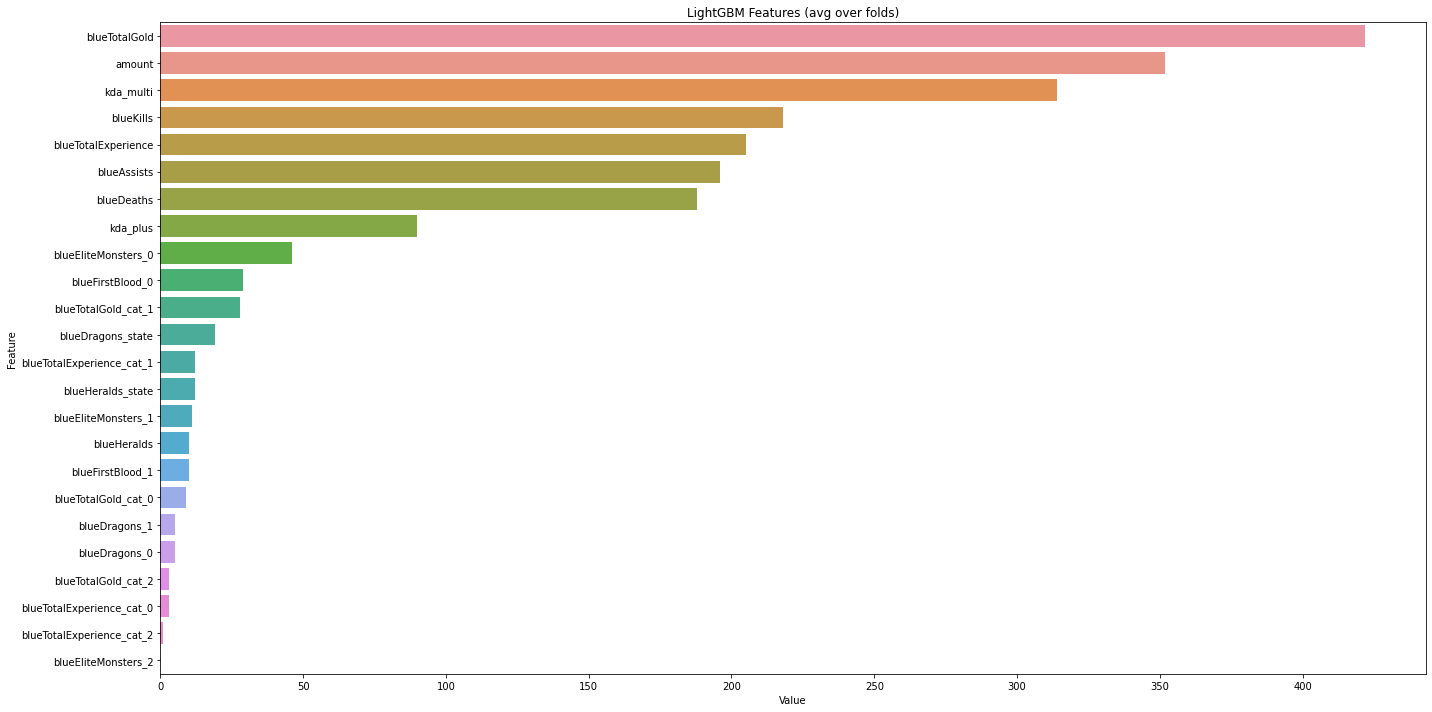

<Figure size 432x288 with 0 Axes>

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),train_x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances_dummeies.png')


In [ ]:
y_pred

array([0.55877962, 0.85455477, 0.50304857, ..., 0.89447168, 0.76506381,
       0.40288247])

In [ ]:

sample_submit[1]= np.where(y_pred>0.5,1,0)
sample_submit.to_csv('final_optuna.csv',index=False,header=False)
